# **Creating a bot that predicts Rossmann future sales**

## **Rossmann and Business Problem**
<p align="justify"> Rossmann is one of the largest drug store chains in Europe, with operations in Germany, Poland, Hungary, the Czech Republic, Turkey, Albania, Kosovo and Spain. Their sales can be influenced by promotions, competition, school and state holidays, seasonality, locality, etc.</p>

This **Data Science** project is focused on solving one problem: 

 - **Rossmann CEO is requiring a sales prediction of the next six weeks for each store, in order to determine the best resources allocation for each store renovation.**

## 1. **Imports**

#### 1.1 **Libraries**

In [1]:
import re
import random
import numpy as np
import pandas as pd
from math import isnan, comb
from dython.nominal import cramers_v
from datetime import datetime, timedelta

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

from boruta import BorutaPy
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

import pickle
from flask import Flask

pd.set_option('display.float_format', lambda x: '%.5f' % x)

#### 1.2 **Helper Functions**

In [2]:
def to_snake(text):    
    '''
    Converts given text to snake_case.

    Parameters
    ----------
    text : text to be converted.

    Returns
    -------
    text : new text in snake_case.
    '''   
    text = re.sub(r'(?<!^)(?=[A-Z])', '_', text).lower()
    return text

def data_shape(df):
    '''
    Gets the number of rows and columns for a given DataFrame.

    Parameters
    ----------
    df : dataframe on which the function will be applied.
    
    Returns
    -------
    None 
    '''   
    print(f'Number of Rows: {df.shape[0]}')
    print(f'Number of Columns: {df.shape[1]}')
    return None    

def add_period_to_col(df, col, period):
    '''
    Extracts selected period from datetime and creates a new period column(s).

    Parameters
    ----------
    df : dataframe on which the function will be applied.
    col : column new name.
    period : period to be extracted.

    Returns
    -------
    df : dataframe with new period column(s)
    '''    
    if period == 'day':   
        df[col] = df.apply(lambda x: x['date'].day if isnan(x[col]) else x[col],axis=1)
    elif period == 'week':
        df[col] = df.apply(lambda x: x['date'].week if isnan(x[col]) else x[col],axis=1)
    elif period == 'month':
        df[col] = df.apply(lambda x: x['date'].month if isnan(x[col]) else x[col],axis=1)       
    elif period == 'year':
        df[col] = df.apply(lambda x: x['date'].year if isnan(x[col]) else x[col],axis=1) 
    else:
        raise ValueError('Please select period: day, week, month or year')                 
    return df

def to_int_64(df,change_types_list):
    '''
    Changes data type to int64.

    Parameters
    ----------
    df : dataframe on which the function will be applied.
    change_types_list : list of columns on which the function will be applied.

    Returns
    -------
    df : dataframe with new column types.
    '''  
    for i in change_types_list:
        df[f'{i}'] = df[f'{i}'].astype('int64')
    return df

def descriptive_statistics(df, num_attributes):
    '''
    Creates a descriptive statistics table.

    Parameters
    ----------
    df : dataframe on which the function will be applied.
    num_attributes: dataframes's numerical attributes.    
    
    Returns
    -------
    metrics : descriptive statistics table.
    '''
    # Central Tendency 
    ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
    
    # Dispersion 
    d1 = pd.DataFrame(num_attributes.apply(np.std)).T
    d2 = pd.DataFrame(num_attributes.apply(min)).T
    d3 = pd.DataFrame(num_attributes.apply(max)).T
    d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
    
    # Concat
    metrics = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
    metrics.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
    return metrics

def multiple_boxplots(ax, x_list, y, c, figsize=(12,30)):
    '''
    Creates multiple boxplots.

    Parameters
    ----------
    ax: data from which the axis are.
    x_list: x axis columns list.
    y: y axis. 
    c: plot position.
        
    Returns
    -------
    None 
    '''
    for i,j in enumerate(x_list):
        plt.figure(figsize=figsize)            
        plt.subplot(len(x_list),c,i+1)
        sns.boxplot(x=j, y=y, data=ax)
    plt.show()
    return None

def bar_plot(data, x, xlabel, y, ylabel):
    '''
    Creates bar plots.

    Parameters
    ----------
    data: data from which the axis are.
    x: x axis.
    xlabel: x axis label.
    y: y axis.
    ylabel: y axis label.
        
    Returns
    -------
    None 
    '''
    plt.figure(figsize=(10,5))
    ax = sns.barplot(x=x, y=y, data=data)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    plt.ticklabel_format(style='plain', axis='y')
    plt.show() 
    return None   

def cramers_matrix(cat):   
    '''
    Calculates the Cramér's V correlation matrix.

    Parameters
    ----------
    cat: categorical attributes from the data.
        
    Returns
    -------
    None 
    '''
    a1 = cramers_v(cat[cat.columns[0]], cat[cat.columns[0]])
    a2 = cramers_v(cat[cat.columns[0]], cat[cat.columns[1]])
    a3 = cramers_v(cat[cat.columns[0]], cat[cat.columns[2]])
    a4 = cramers_v(cat[cat.columns[1]], cat[cat.columns[0]])
    a5 = cramers_v(cat[cat.columns[1]], cat[cat.columns[1]])
    a6 = cramers_v(cat[cat.columns[1]], cat[cat.columns[2]])
    a7 = cramers_v(cat[cat.columns[2]], cat[cat.columns[0]])
    a8 = cramers_v(cat[cat.columns[2]], cat[cat.columns[1]])
    a9 = cramers_v(cat[cat.columns[2]], cat[cat.columns[2]])

    matrix = pd.DataFrame({'state_holiday':[a1, a2, a3],
                           'store_type':   [a4, a5, a6],
                           'assortment':   [a7, a8, a9] })

    matrix = matrix.set_index(matrix.columns)
    
    plt.figure(figsize=(20,12))
    sns.heatmap(matrix, annot=True)
    plt.show()    
    return None     

def nature_encode(df, col, div_period):
    '''
    Applies a Nature Cyclical Transformation, where each period
    is a combination of sin and cos.
    
    Parameters
    ----------
    df : dataframe on which the function will be applied.
    col : period column on which the function will be applied.
    div_period : amount of periods until the cycle restarts (e.g. month=12, week=7, etc).

    Returns
    -------
    None
    '''  
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/div_period)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/div_period)
    return None

def ml_error(model_name, y_true, y_pred):
    '''
    Calculates metrics for the ML model, such as 
    MAE, MAPE, RMSE and R2.
    
    Parameters
    ----------
    model_name : model name.
    y_true : true values for the response variable.
    y_pred : predicted values for the response variable.

    Returns
    -------
    DataFrame: Contains Model Name, MAE, MAPE, RMSE and R2.
    '''  
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': np.round(mae,2),
                         'MAPE': np.round(mape,4),
                         'RMSE': np.round(rmse,2),
                         'R2': np.round(r2,4)}, index=[0])
    
def cross_validation(training, k_fold, model_name, model, verbose=False):
    '''
    Splits the data into train and validation, fits the given model for each k_fold, 
    makes predictions and returns a DataFrame with the mean +/- std (of k models) for 
    four performance metrics: MAE, MAPE, RMSE and R2.
    
    Parameters
    ----------
    training : the X_train dataset + 'sales' and 'date', because the function cross_validation uses both columns ('sales' and 'date') to split data into train (x,y) and validation (x,y).
    
    k_fold : number of folds in cross validation. For all models k_fold=5 will be used.
    
    model_name : the model name as a string.
    
    model : the initialized model (e.g. LinearRegression(), SVR(), etc).

    Returns
    -------
    DataFrame: Contains cross-validation Model Name, MAE, MAPE, RMSE and R2.
    '''  
    mae_list = []
    mape_list = []
    rmse_list = []
    r2_list = []

    for k in reversed(range(1,k_fold + 1)):
        if verbose:
            print(f'\n KFold Iteration {k}')
        # Start/End date for validation
        val_start_date = training['date'].max() - timedelta(days=k*6*7) 
        val_end_date = training['date'].max() - timedelta(days=(k-1)*6*7)

        # Filtering dataset
        training2 = training[training['date'] < val_start_date] # Training data 
        val =  training[(training['date'] >= val_start_date) & (training['date'] <= val_end_date)] # Validation data

        # Training dataset
        xtraining = training2.drop(['date','sales'],axis=1)
        ytraining = training2['sales']

        # Validation dataset
        xval = val.drop(['date','sales'],axis=1)
        yval = val['sales']

        # Model
        m = model.fit(xtraining, ytraining)

        # Prediction
        y_pred = m.predict(xval)

        # Metrics
        result = ml_error(model_name, np.expm1(yval), np.expm1(y_pred))
        
        # Storing the performance of each kfold iteration        
        mae_list.append(result['MAE'])
        mape_list.append(result['MAPE'])
        rmse_list.append(result['RMSE'])
        r2_list.append(result['R2'])
        
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': np.round(np.mean(mae_list),2).astype(str) + ' +/- ' + np.round(np.std(mae_list),2).astype(str),
                         'MAPE': np.round(np.mean(mape_list),4).astype(str) + ' +/- ' + np.round(np.std(mape_list),4).astype(str),
                         'RMSE': np.round(np.mean(rmse_list),2).astype(str) + ' +/- ' + np.round(np.std(rmse_list),2).astype(str),
                         'R2': np.round(np.mean(r2_list),4).astype(str) + ' +/- ' + np.round(np.std(r2_list),4).astype(str)}, index=[0]) 
    
def random_search_lgbm(search_space, training, trials):
    '''
    Applies Random Search Hyperparameter Optimization on LGBM Regressor model.
        
    Parameters
    ----------
    search_space : dictionary of parameters on which the algorithm will search for.
    
    training : training data + sales and data columns, so that the data can be split.
    
    trials : number of parameters combinations, in other words the amount of different LGBM models.
    
    Returns
    -------
    final_comparisons: dataframe containing all estimated LGBM models, with their respective metrics.
    '''  
    final_comparisons = pd.DataFrame()    
    for i in range(trials):       
        hp = {k: random.sample(v, 1)[0] for k, v in search_space.items()}  # choosing values for parameters randomly
        print(hp)

        # Model
        model = LGBMRegressor(objective='regression', 
                                random_state=42,
                                subsample=0.7, # prevent over-fitting  
                                colsample_bytree=0.9, # prevent over-fitting  
                                min_child_samples=100, # prevent over-fitting  
        
                                n_estimators=hp['n_estimators'],
                                learning_rate=hp['learning_rate'],
                                max_depth=hp['max_depth'],
                                num_leaves=hp['num_leaves'])

        # Performance
        result = cross_validation(training, 5, 'LGBM Regressor', model, verbose=True)
        final_comparisons = pd.concat([final_comparisons, result])

    return final_comparisons  

#### 1.3 **Loading Data**

In [3]:
df_sales_raw = pd.read_csv('../data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('..data/store.csv', low_memory=False)

# Merge data
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

## 2. **Data Descriptions**

In [4]:
df1 = df_raw.copy()

| Feature | Definition |
|---|---|
| Id | an Id that represents a (Store, Date) duple within the dataset.|
| Store | a unique Id for each store.|
| Sales | the turnover for any given day.|
| DayOfWeek | day of week on which the sale was made (e.g. DayOfWeek=1 -> monday, DayOfWeek=2 -> tuesday, etc).|
| Date | date on which the sale was made.|
| Customers | the number of customers on a given day.|
| Open | an indicator for whether the store was open: 0 = closed, 1 = open.|
| StateHoliday | indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None.|
| SchoolHoliday  | indicates if the (Store, Date) was affected by the closure of public schools.|
| StoreType  | differentiates between 4 different store models: a, b, c, d.|
| Assortment | describes an assortment level: a = basic, b = extra, c = extended.|
| CompetitionDistance | distance in meters to the nearest competitor store.|
| CompetitionOpenSince(Month/Year)| gives the approximate year and month of the time the nearest competitor was opened.|
| Promo | indicates whether a store is running a promo on that day.|
| Promo2 | Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating.|
| Promo2Since(Year/Week)| describes the year and calendar week when the store started participating in Promo2.|
| PromoInterval | describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store.|

#### 2.1 **Rename Columns**

The columns will be renamed to snake_case style.

In [5]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [6]:
cols = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 
        'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 
        'Assortment', 'CompetitionDistance','CompetitionOpenSinceMonth',
        'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
        'Promo2SinceYear', 'PromoInterval']

In [7]:
# Applying to_snake function
snake = lambda x: to_snake(x) 
new_cols = list(map(snake, cols))

# Renaming
df1.columns = new_cols

#### 2.2 **Data Dimensions**

In [8]:
data_shape(df1)

Number of Rows: 1017209
Number of Columns: 18


#### 2.3 **Data Types**

In [9]:
df1['date'] = pd.to_datetime(df1['date'])

In [10]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

#### 2.4 **Check NaN's**

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

Some columns have NaN's present in them, therefore those will have to be dealt with.

#### 2.5 **Fillout NaN's**

2.5.1 **competition_distance**

The competition_distance column indicates "distance in meters to the nearest competitor store". Thus, the observations with NaN's are likely stores that are too far, which means there's no competition. For that reason, the NaN's in competition_distance will be replaced by 3 times the maximum competition_distance in the dataset.

In [12]:
max_comp = 3*df1['competition_distance'].max() # Getting the max competition_distance * 3
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: max_comp if isnan(x) else x) # If NaN is present the competition_distance will be = max_comp

2.5.2 **competition_open_since_month & competition_open_since_year**

 There are two reasons that can explain why NaN's are present in competition_open_since columns:
- The store doesn't have cat near competitor
- We don't know when the competition opened that store, either because it happened so long ago, or because it wasn't recorded

To treat these missing values the respective month and year of that sale will replace the NaN in both competition_open_since_month and competition_open_since_year.

In [13]:
# If nan is present the column, get the month/year from the 'date' column, and add it to competition_open_since_month/year, if not this leave the original value
df1 = add_period_to_col(df1, 'competition_open_since_month', 'month')
df1 = add_period_to_col(df1, 'competition_open_since_year', 'year')

2.5.3 **promo2_since_week & promo2_since_year**

If promo2_since_week and promo2_since_year have missing values, it means the store didn't participate in any promotion. To treat these missing values the respective year and week of that sale will replace the NaN in both promo2_since_week and promo2_since_year.

In [14]:
df1 = add_period_to_col(df1, 'promo2_since_week', 'week')
df1 = add_period_to_col(df1, 'promo2_since_year', 'year')

2.5.4 **promo_interval**

In [15]:
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'} # Creates a months dict
df1['promo_interval'].fillna(0, inplace=True) # Fill all Nan's with 0
df1['month_map'] = df1['date'].dt.month.map(month_map) # Creates a column named 'month_map' that gets the sale month for each observation and adds it as text (e.g. if month=1 -> month_map = 'Jan')
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1)

#### 2.6 **Change Types**

In [16]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [17]:
# Converting to int64
df1 = to_int_64(df1, ['competition_open_since_month',
                             'competition_open_since_year',
                             'promo2_since_week',
                             'promo2_since_year'])

#### 2.7 **Descriptive Statistics**

2.7.1 **Numerical Attributes**

In [18]:
# Getting only the numerical attributes
num_attributes = df1.select_dtypes(include=['int64', 'float64']).drop(columns=['store'],axis=1)

In [19]:
# Descriptive Statistics
descriptive_statistics(df1, num_attributes)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,day_of_week,1.00000,7.00000,6.00000,3.99834,4.00000,1.99739,0.00159,-1.24687
1,sales,0.00000,41551.00000,41551.00000,5773.81897,5744.00000,3849.92428,0.64146,1.77837
2,customers,0.00000,7388.00000,7388.00000,633.14595,609.00000,464.41151,1.59865,7.09177
3,open,0.00000,1.00000,1.00000,0.83011,1.00000,0.37554,-1.75804,1.09072
4,promo,0.00000,1.00000,1.00000,0.38151,0.00000,0.48576,0.48784,-1.76202
5,school_holiday,0.00000,1.00000,1.00000,0.17865,0.00000,0.38306,1.67784,0.81515
6,competition_distance,20.00000,227580.00000,227560.00000,6007.07629,2330.00000,13682.72842,11.51297,177.13626
7,competition_open_since_month,1.00000,12.00000,11.00000,6.78685,7.00000,3.31109,-0.04208,-1.23261
8,competition_open_since_year,1900.00000,2015.00000,115.00000,2010.32484,2012.00000,5.51559,-7.23566,124.07130
9,promo2,0.00000,1.00000,1.00000,0.50056,1.00000,0.50000,-0.00226,-2.00000


2.7.2 **Categorical Attributes**

In [20]:
# Getting only the categorical attributes
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64','datetime64[ns]'])
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

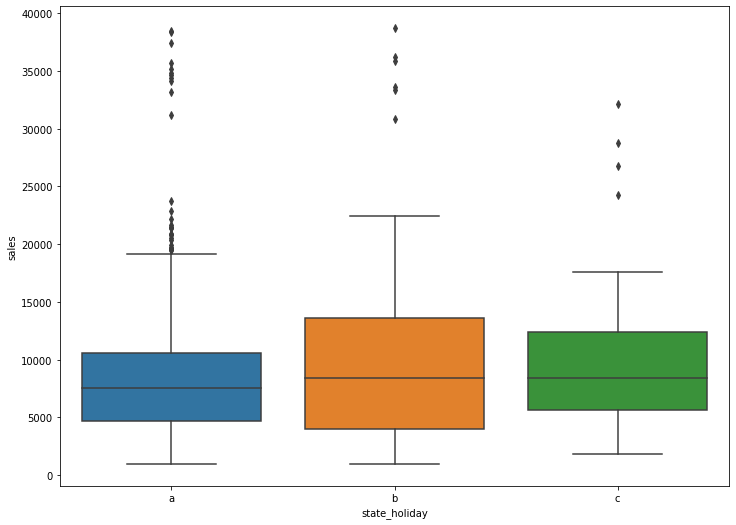

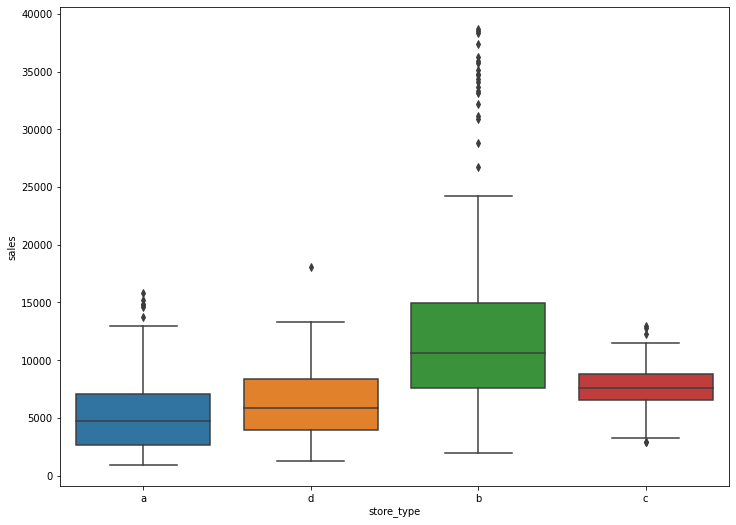

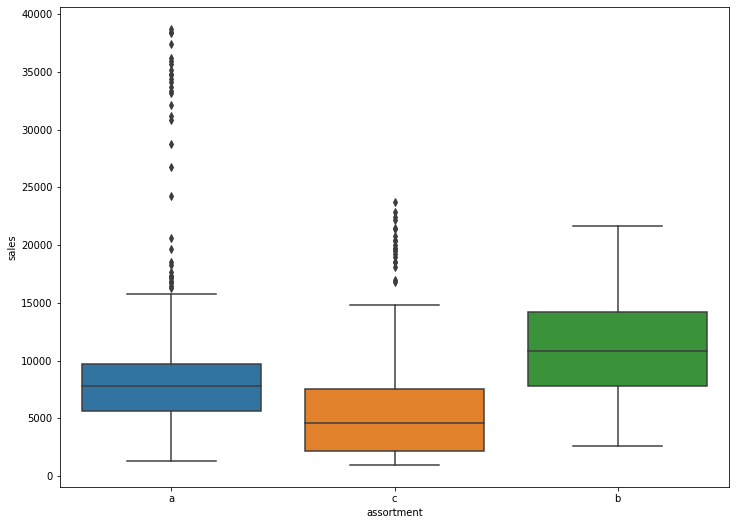

In [21]:
ax = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)] # Get only stores with state holidays, and days where sales were made (sales=0 means the stores were closed)
x_list = ['state_holiday','store_type','assortment']
multiple_boxplots(ax=ax,x_list=x_list,y='sales',c=1)

## 3. **Feature Engineering**

In [22]:
df2 = df1.copy()

#### 3.1 **Hypotheses Mindmap**

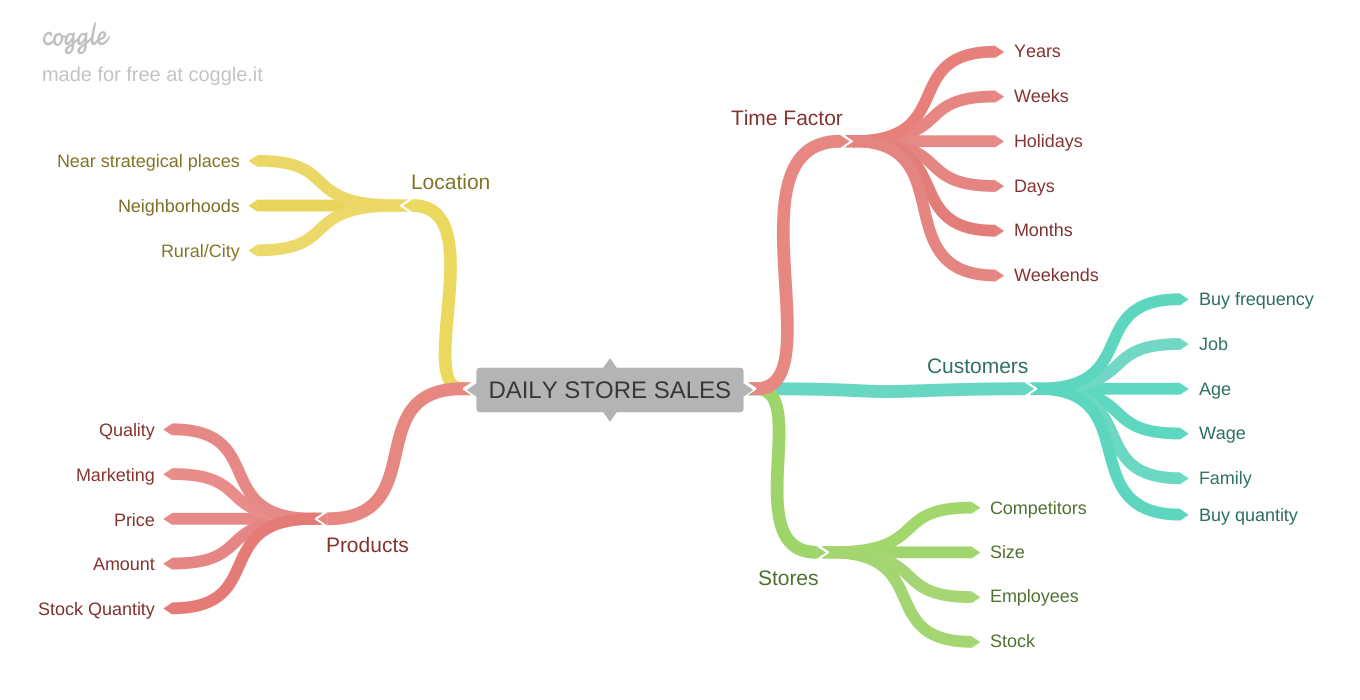

In [23]:
Image('C:/Users/bruno/OneDrive/Documentos/repos/data-science-em-producao/images/mindmap_daily_store_sales.png', width=900)

#### 3.2 **Hypotheses Creation**

3.2.1 **Store Hypotheses**

- **H1:** Stores with higher number of employees are supposed to sell more.
- **H2:** Stores with higher stock capacity are supposed to sell more.
- **H3:** Bigger stores are supposed to sell more.
- **H4:** Stores with higher assortment level are supposed to sell more.
- **H5:** Stores with higher number of close competitors are supposed to sell less.

3.2.2 **Product Hypotheses**

- **H1:** Stores with higher marketing investment are supposed to sell more.
- **H2:** Stores with lower prices are supposed to sell more.
- **H3:** Stores that keep lower prices for longer periods are supposed to sell more.
- **H4:** Stores with more aggressive promotions (higher discounts) are supposed to sell more.
- **H5:** Stores that keep promotions for longer periods are supposed to sell more.
- **H6:** Stores with more consecutive promotions are supposed to sell more.

3.2.3 **Time Hypotheses**

- **H1:** Christmas has the highest average sales, in comparison to other periods.
- **H2:** Stores are supposed to sell more over the years (year trend).
- **H3:** Stores are supposed to sell more during the second semester of each years (semester trend).
- **H4:** Stores are supposed to sell more after the 10th day of each month. 
- **H5:** Stores are supposed to sell less during the weekend.
- **H6:** Stores are supposed to sell less during school holidays.

#### 3.3 **Final Hypotheses List**

In order to choose the final hypotheses it's important to check whether there's enough data available, so that those hypotheses could be verified. The ones that match such criteria are:

- **H1:** Stores with higher assortment level are supposed to sell more.
- **H2:** Stores with higher number of close competitors are supposed to sell less.
- **H3:** Stores that keep promotions for longer periods are supposed to sell more.
- **H4:** Stores with more consecutive promotions are supposed to sell more.
- **H5:** Christmas has the highest average sales, in comparison to other periods.
- **H6:** Stores are supposed to sell more over the years (year trend).
- **H7:** Stores are supposed to sell more during the second semester of each years (semester trend).
- **H8:** Stores are supposed to sell more after the 10th day of each month. 
- **H9:** Stores are supposed to sell less during the weekend.
- **H10:** Stores are supposed to sell less during school holidays.

#### 3.4 **Creating New Features**

In [24]:
df2.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'month_map', 'is_promo'],
      dtype='object')

In [25]:
# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype('int64')

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# month
df2['month'] = df2['date'].dt.month

# year
df2['year'] = df2['date'].dt.year

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1), axis=1) # %Y-%m-%d date from competition start
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int) # Amount of months from competition start

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) +'-' +df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.strptime(x + '-1', '%Y-%W-%w') - timedelta(days=7)) # Sets the promo_since to %Y-%m-%d date
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int) # Time in weeks from when the promotion was active

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x=='a'
                                                 else 'extra' if x=='b' 
                                                 else 'extended')
# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x=='a'
                                                            else 'easter_holiday' if x=='b' 
                                                            else 'christmas' if x=='c'
                                                            else 'regular_day')                

In [26]:
# Converting to int64 
df2 = to_int_64(df2, ['competition_open_since_month',
                             'competition_open_since_year',
                             'promo2_since_week',
                             'promo2_since_year'])

## 4. **Feature Filtering**

In [27]:
df3 = df2.copy()

In [28]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'month_map', 'is_promo', 'day',
       'week_of_year', 'year_week', 'month', 'year', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

In [29]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,day,week_of_year,year_week,month,year,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,31,31,2015-30,7,2015,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,31,31,2015-30,7,2015,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,31,31,2015-30,7,2015,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,31,31,2015-30,7,2015,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,31,31,2015-30,7,2015,2015-04-01,4,2015-07-27,0


#### 4.1 **Rows Filtering**

- Rows were 'open'=0 will be removed, since those were days the store was closed, hence no sales were made.
- Rows were 'sales'=0 will also be removed, because there's only interest in observations on which sales were made.

In [30]:
df3 = df3[(df3['open']!=0)&(df3['sales']>0)] # Only get the rows where 'open'!=0 & 'sales'>0

#### 4.2 **Columns Selection**

- 'customers' will be dropped, because for now there's no information about the amount of customers six weeks into the future. 
- 'open' will be dropped, since the rows where 'open'=0 were already removed.
- 'promo_interval' and 'month_map' were used as auxiliary columns (columns used so that other features could be created), therefore those will also be removed.

In [31]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map'] # list with cols to be dropped 
df3 = df3.drop(cols_drop, axis=1)

## 5. **Exploratory Data Analysis (EDA)**

EDA main objectives are:
- Obtain business experience.
- Validate business hypotheses (insights).
- Find important features for the ML model. 

In [32]:
df4 = df3.copy()

#### 5.1. **Univariate Analysis**

5.1.1. **Response Variable (Sales)**

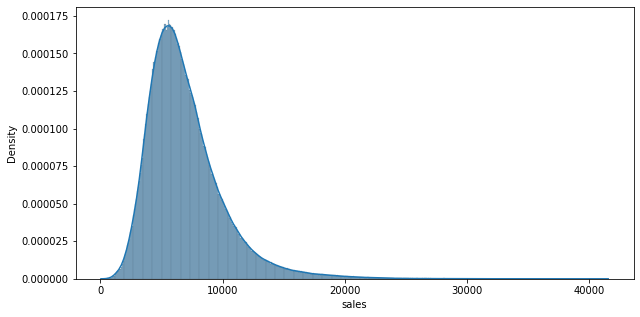

In [33]:
# Kernel Density Estimate (KDE) - Sales Plot (df4)
plt.figure(figsize=(10,5))
sns.histplot(df4['sales'], kde=True, stat='density');

5.1.2. **Numerical Variables**

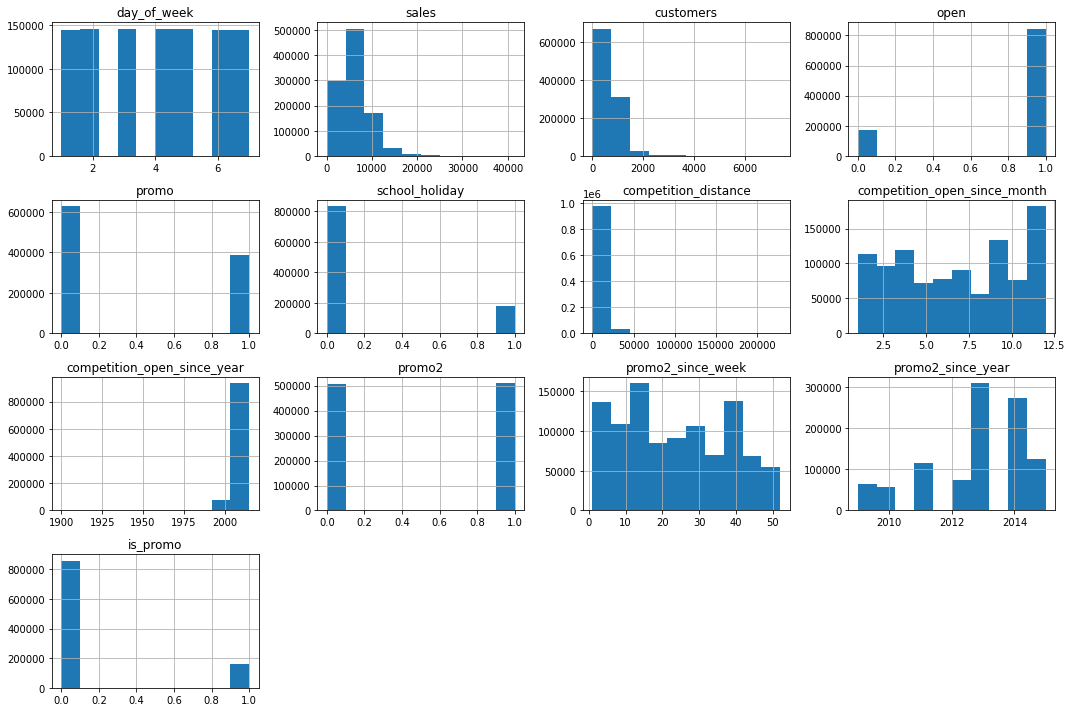

In [34]:
# Histogram plot for all numerical variables
num_attributes.hist(figsize=(15,10));
plt.tight_layout()
plt.show()

The only numerical variables that are close to follow a behaved distribution are 'sales' and 'customers'.

5.1.3. **Categorical Variables**

In [35]:
df4['assortment'].value_counts()

basic       444875
extended    391254
extra         8209
Name: assortment, dtype: int64

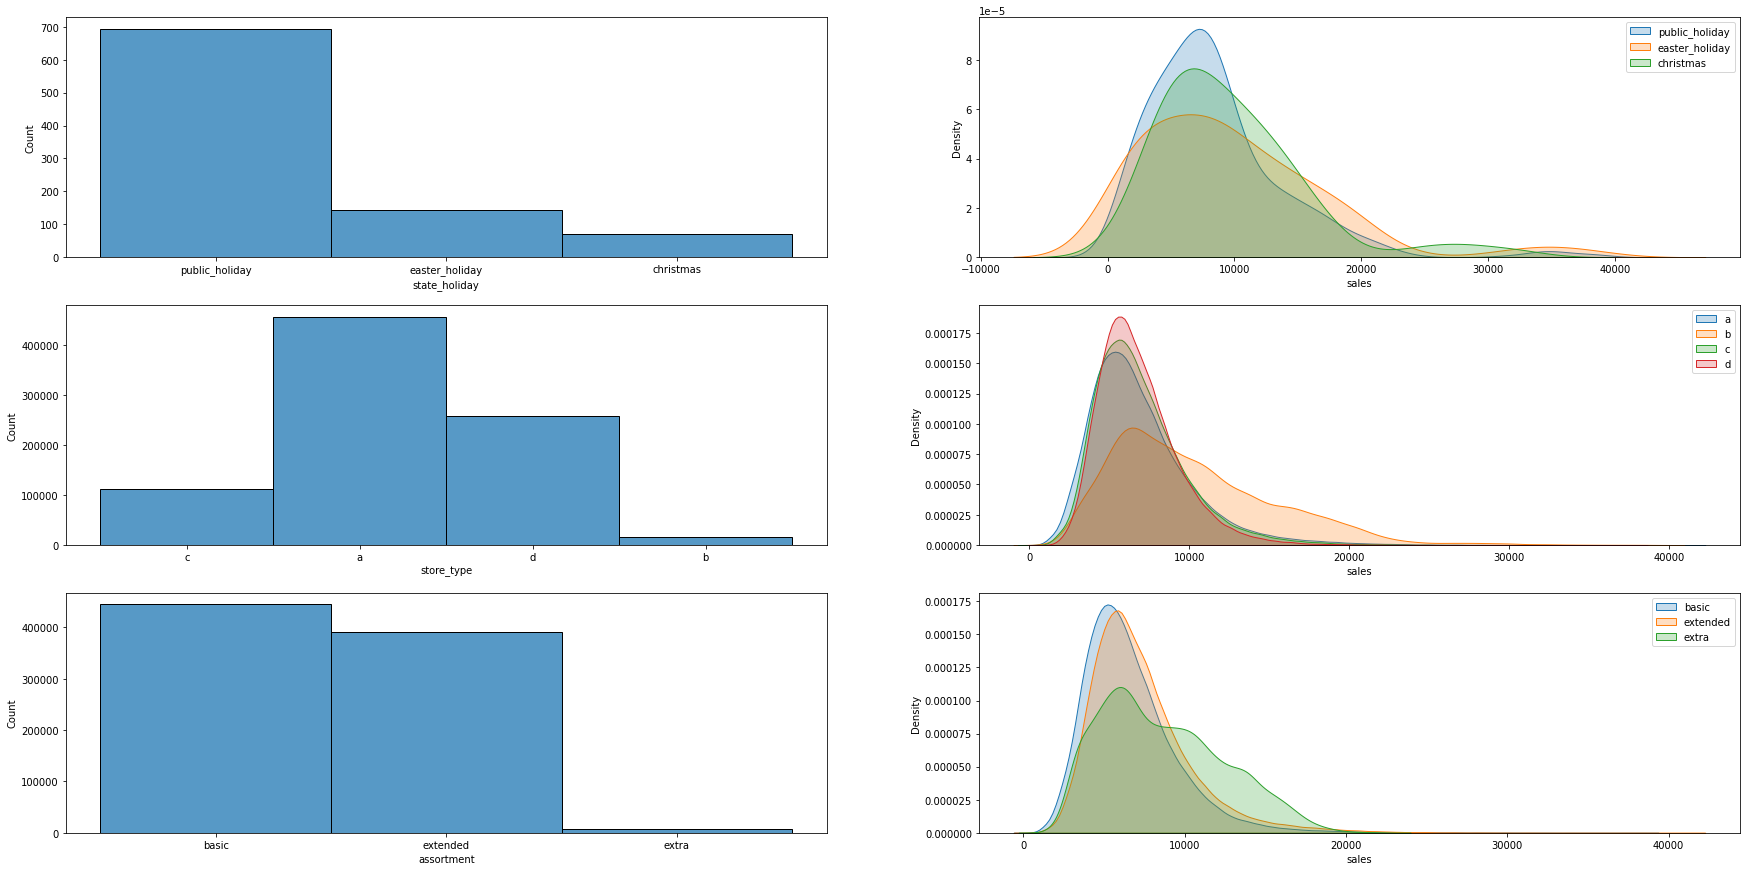

In [36]:
plt.figure(figsize=(30,15))

# state_holiday
plt.subplot(3,2,1)
no_regular = df4[df4['state_holiday'] != 'regular_day']
sns.histplot(no_regular['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday']== 'public_holiday']['sales'],label='public_holiday',fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'],label='easter_holiday',fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'],label='christmas',fill=True)
plt.legend(loc='upper right')

# store_type hist and kde plot
plt.subplot(3,2,3)
sns.histplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'],label='a',fill=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'],label='b',fill=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'],label='c',fill=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'],label='d',fill=True)
plt.legend(loc='upper right')

# assortment hist and kde plot
plt.subplot(3,2,5)
sns.histplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'],label='basic',fill=True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'],label='extended',fill=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'],label='extra',fill=True)
plt.legend(loc='upper right')

plt.show()

#### 5.2. **Bivariate Analysis**

##### **H1:** Stores with higher assortment level are supposed to sell more.
  
 **FALSE**: Stores with basic assortment level are the ones that sell more. 

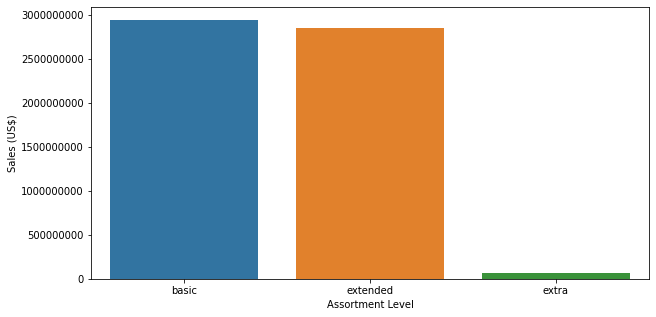

In [37]:
df_assortment = df4[['sales','assortment']].groupby('assortment').sum().reset_index() # Grouping Sales by Assortment Level
bar_plot(df_assortment,'assortment','Assortment Level', 'sales', 'Sales (US$)')

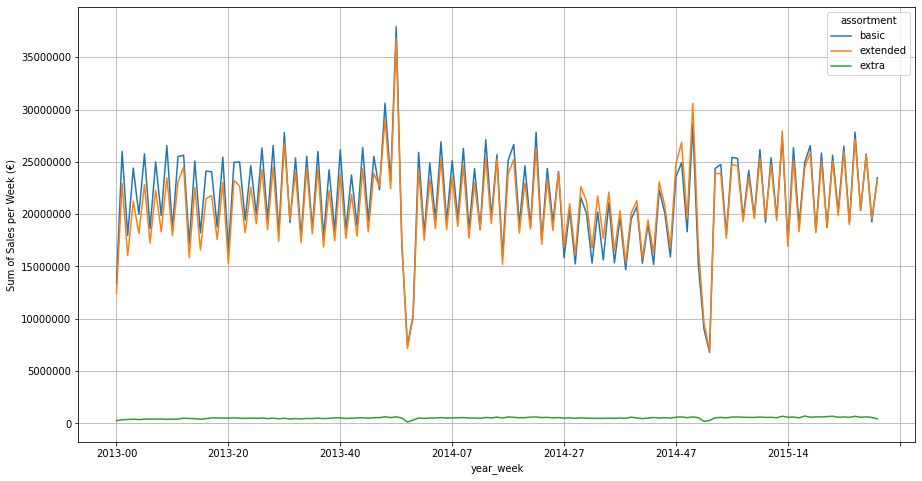

In [38]:
# Assortment Time Series
df_assortment_2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment'] ).sum().reset_index()
df_assortment_2.pivot(index='year_week', columns='assortment', values='sales').plot(figsize=(15,8), grid=True, ylabel='Sum of Sales per Week (€)')
plt.ticklabel_format(style='plain', axis='y');

Since the scales are too different from extra assortment in comparison to the other two, it's important to plot the extra assortment alone:

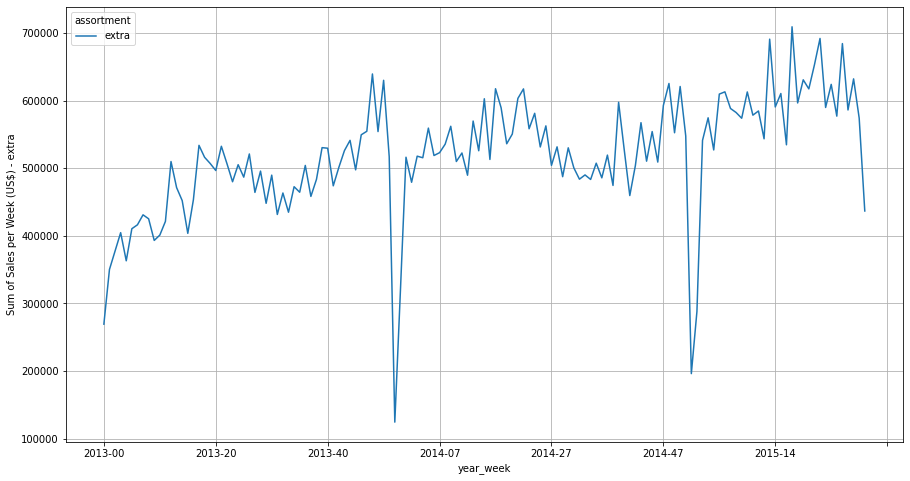

In [39]:
# Assortment=extra Time Series
df_assortment_3 = df_assortment_2[df_assortment_2['assortment'] == 'extra']
df_assortment_3.pivot(index='year_week', columns='assortment', values='sales').plot(figsize=(15,8), grid=True, ylabel='Sum of Sales per Week (US$) - extra');

##### **H2:** Stores with higher number of close competitors are supposed to sell less.

**FALSE**: Stores with higher number of close competitors sell more. 

In [40]:
desc = descriptive_statistics(df4, num_attributes)
desc[desc['attributes']=='competition_distance']

,attributes,min,max,range,mean,median,std,skew,kurtosis
6,competition_distance,20.00000,227580.00000,227560.00000,6007.07629,2330.00000,13682.72842,11.51297,177.13626


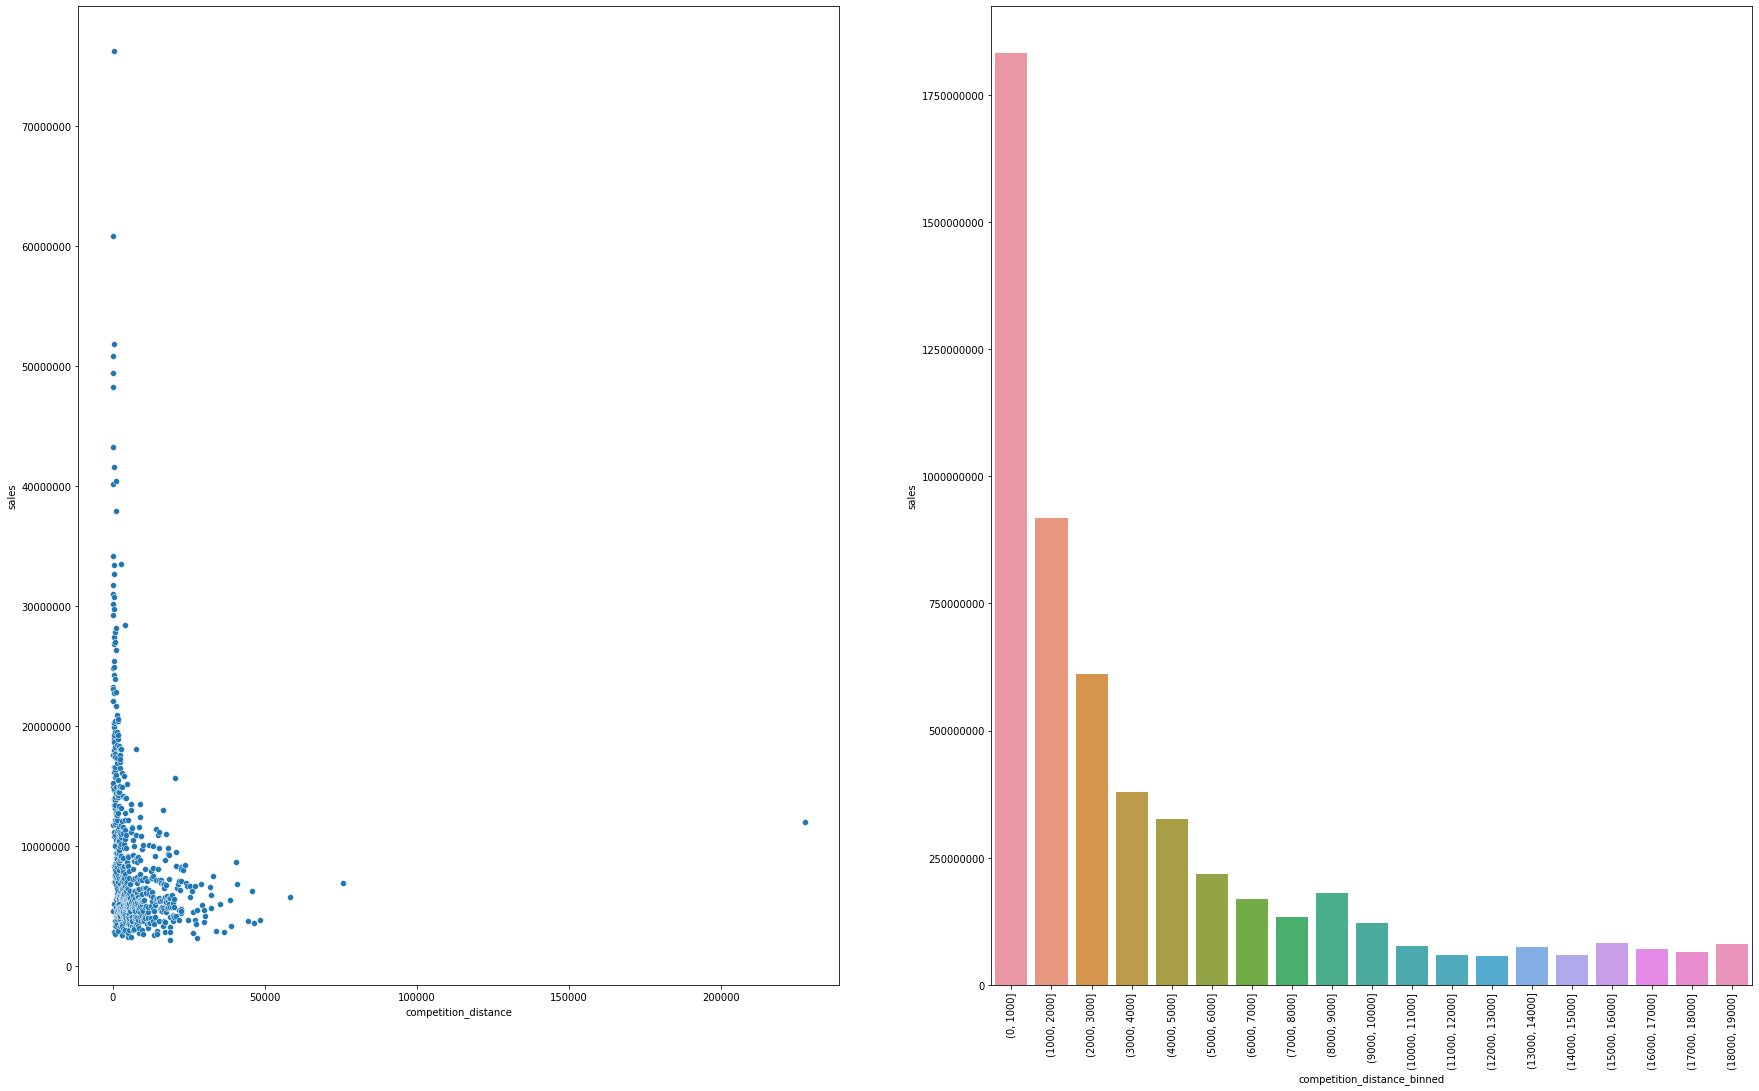

In [41]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index() # Grouping Sales by Competition Distance

plt.figure(figsize=(30,18)) 

plt.subplot(1, 2, 1)
sns.scatterplot(x ='competition_distance', y='sales', data=aux1) # Scatter plot of competition_distance x sales
plt.ticklabel_format(style='plain', axis='y') # Avoiding scientific notation on y axis

plt.subplot(1, 2, 2)
bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned',y='sales', data=aux2)
plt.xticks(rotation=90) # Rotating the x axis for better visualization 
plt.ticklabel_format(style='plain', axis='y')

plt.show()

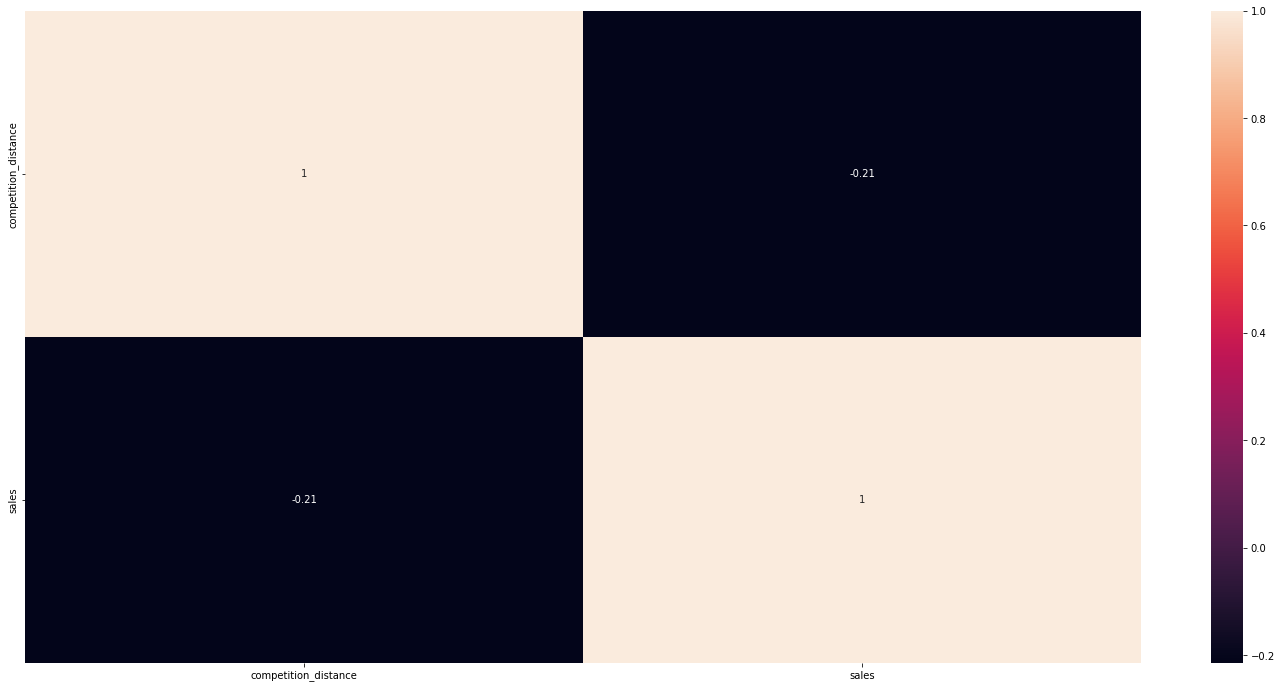

In [42]:
plt.figure(figsize=(25,12)) 
sns.heatmap(aux1.corr(method='pearson'), annot=True) # Correlation heatmap
plt.show()

##### **H3:** Stores that keep promotions for longer periods are supposed to sell more.

**FALSE**: Stores that keep promotions for longer periods sell less after a certain period of time.

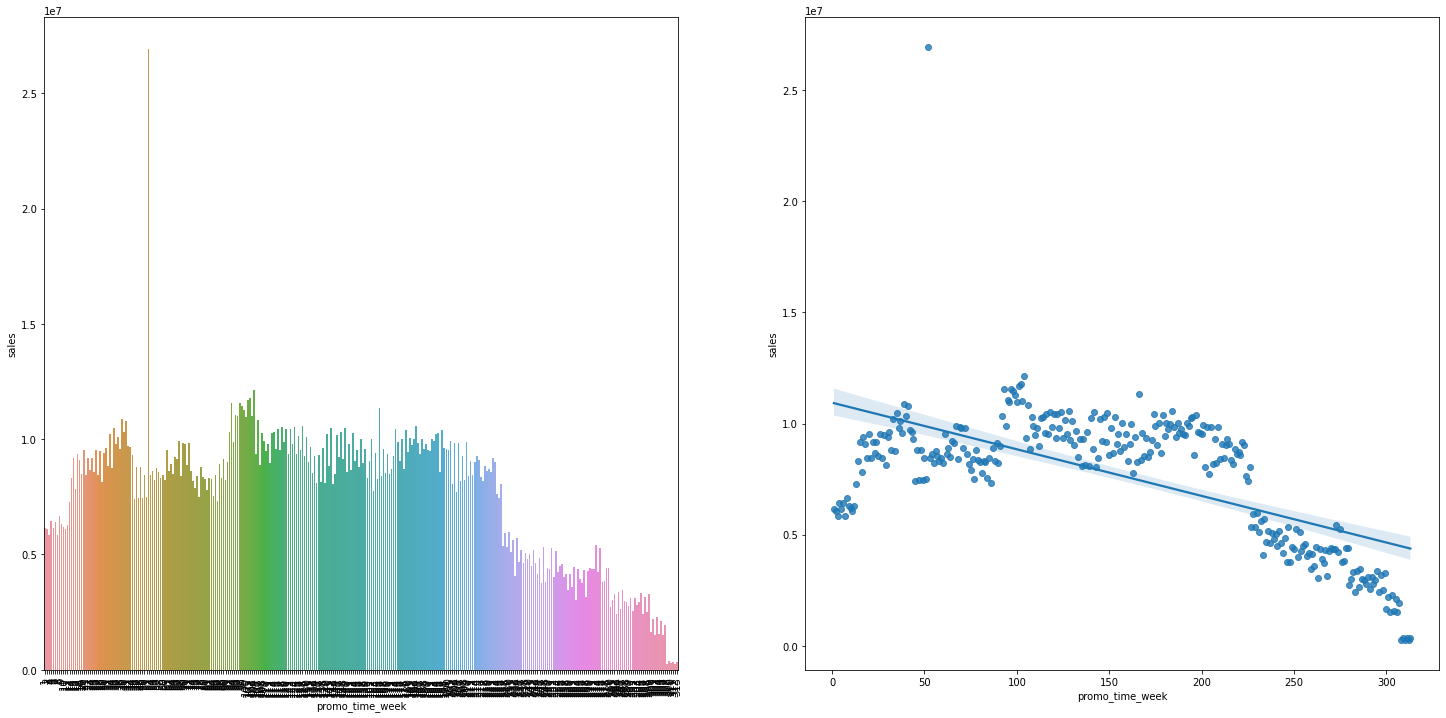

In [43]:
# Grouping sales by promo_time_week (time in weeks from when the promotion was active)
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
plt.figure(figsize=(25,12))

# Extended promotion period
plt.subplot(1,2,1)
aux_ext = aux1[aux1['promo_time_week'] > 0] 
sns.barplot(x='promo_time_week', y='sales', data=aux_ext)
plt.xticks(rotation=90)

plt.subplot(1,2,2)
sns.regplot(x='promo_time_week', y='sales', data=aux_ext)

plt.show()

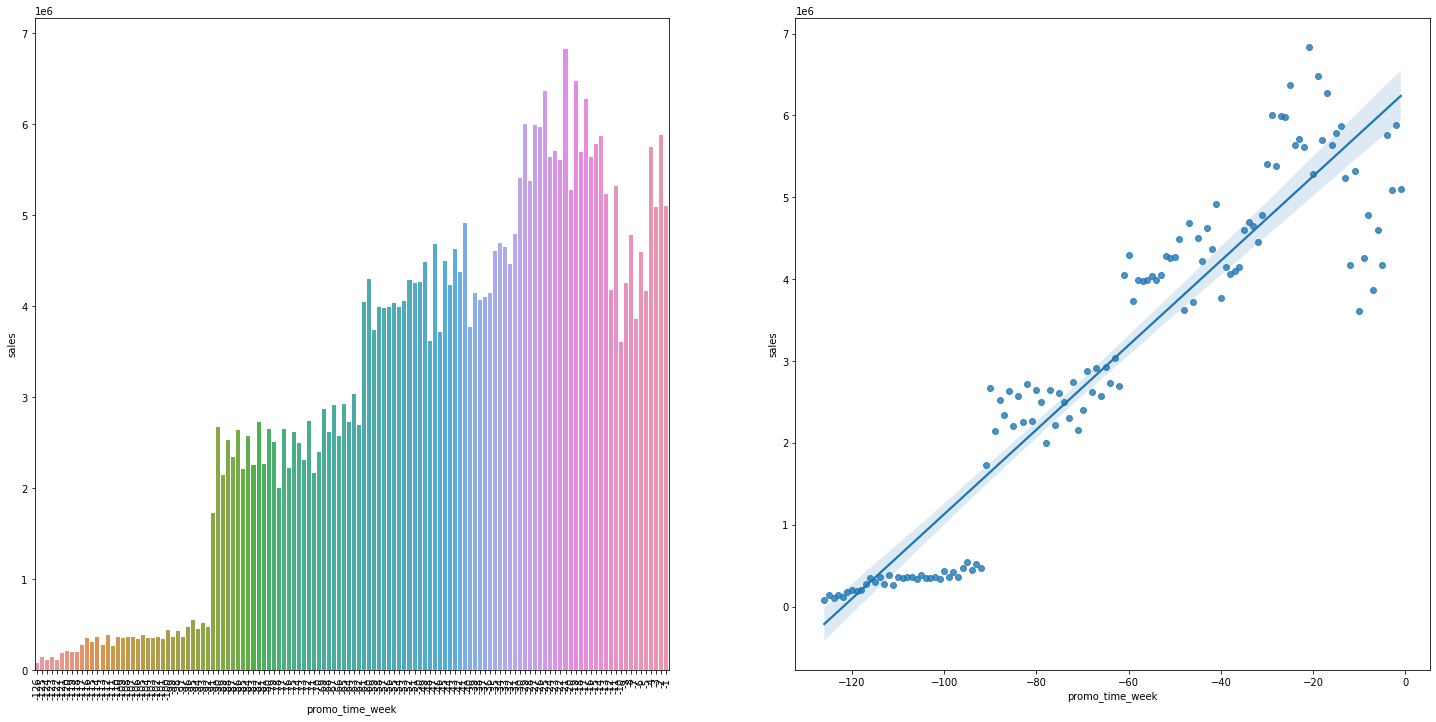

In [44]:
plt.figure(figsize=(25,12))

# Regular promotion period
plt.subplot(1,2,1)
aux_reg = aux1[aux1['promo_time_week'] < 0] 
sns.barplot(x='promo_time_week', y='sales', data=aux_reg)
plt.xticks(rotation=90)

plt.subplot(1,2,2)
sns.regplot(x='promo_time_week', y='sales', data=aux_reg)

plt.show()

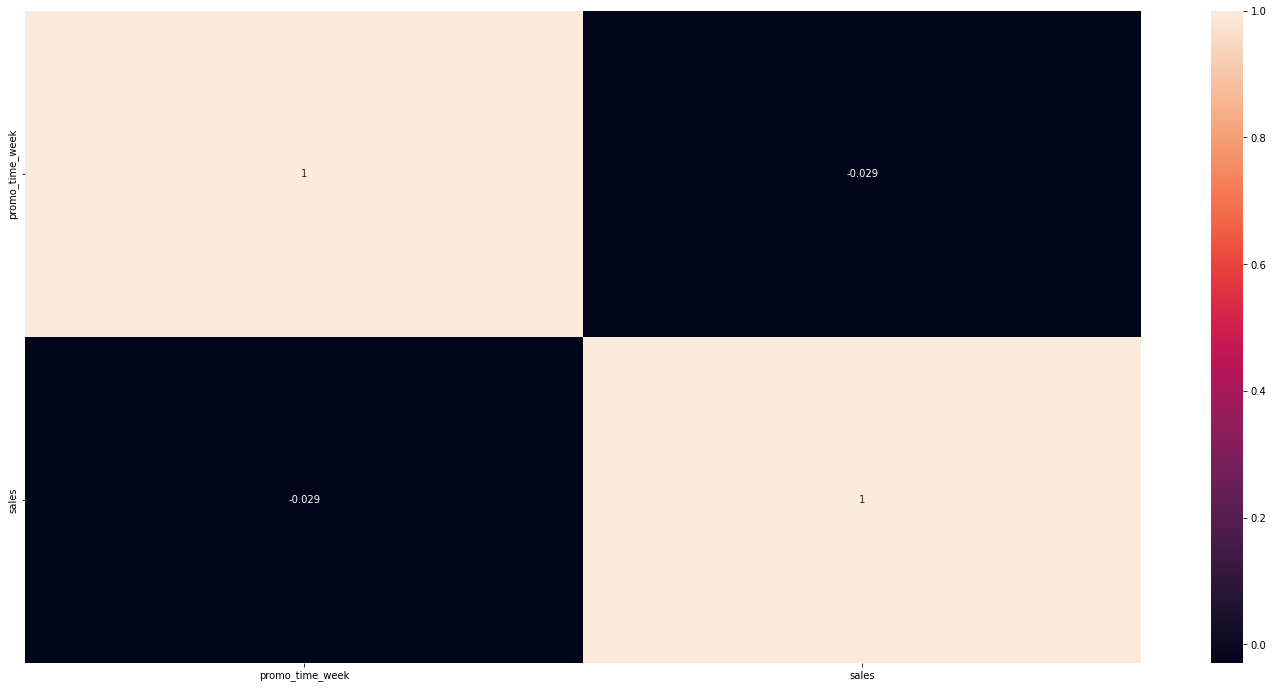

In [45]:
plt.figure(figsize=(25,12))
sns.heatmap(aux1.corr( method='pearson'), annot=True)

plt.show()

##### **H4:** Stores that participate in more consecutive promotions are supposed to sell more.

**FALSE**: Stores that participate in more consecutive promotions sell less.

In [46]:
df4[['sales','promo2','promo']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


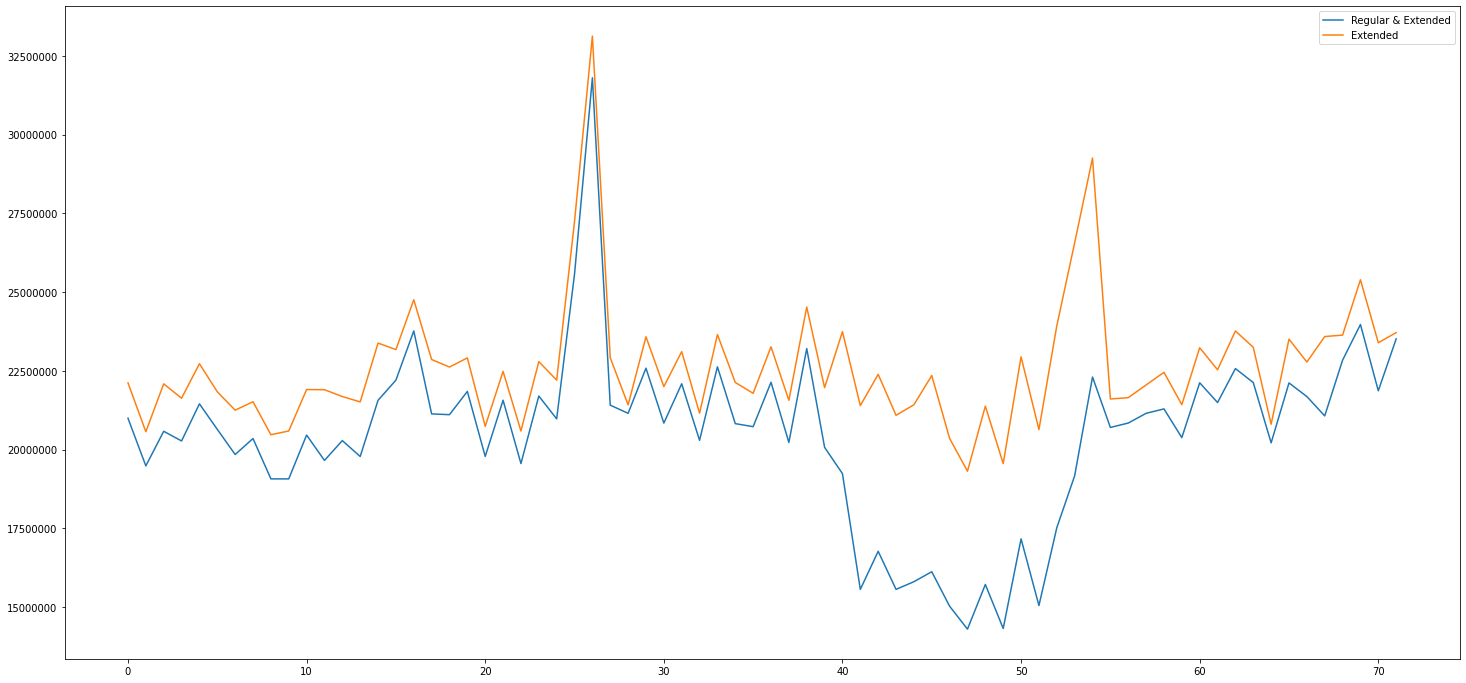

In [47]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot(figsize=(25,12))
aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)
ax.legend(labels=['Regular & Extended', 'Extended'])
plt.ticklabel_format(style='plain', axis='y')

plt.show()

##### **H5:** Christmas has the highest average sales, in comparison to other periods.

**FALSE**: Easter Holiday has the highest average sales, in comparison to other periods.

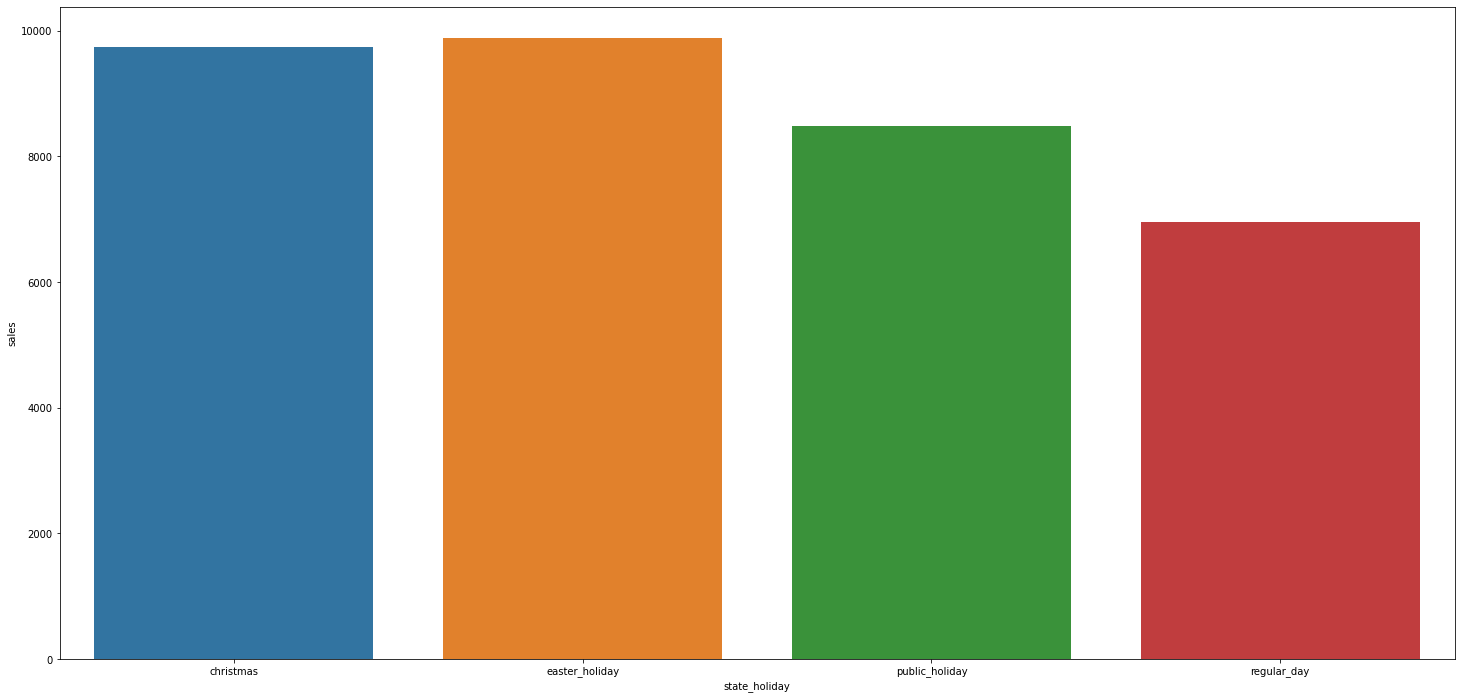

In [48]:
aux1 = df4[['state_holiday','sales']].groupby('state_holiday').mean().reset_index()

plt.figure(figsize=(25,12))
sns.barplot(x='state_holiday',y='sales', data=aux1);

##### **H6:** Stores are supposed to sell more over the years (year trend).

**FALSE**: There's a negative trend over the years in sales magnitude (despite 2015 not having the full data).

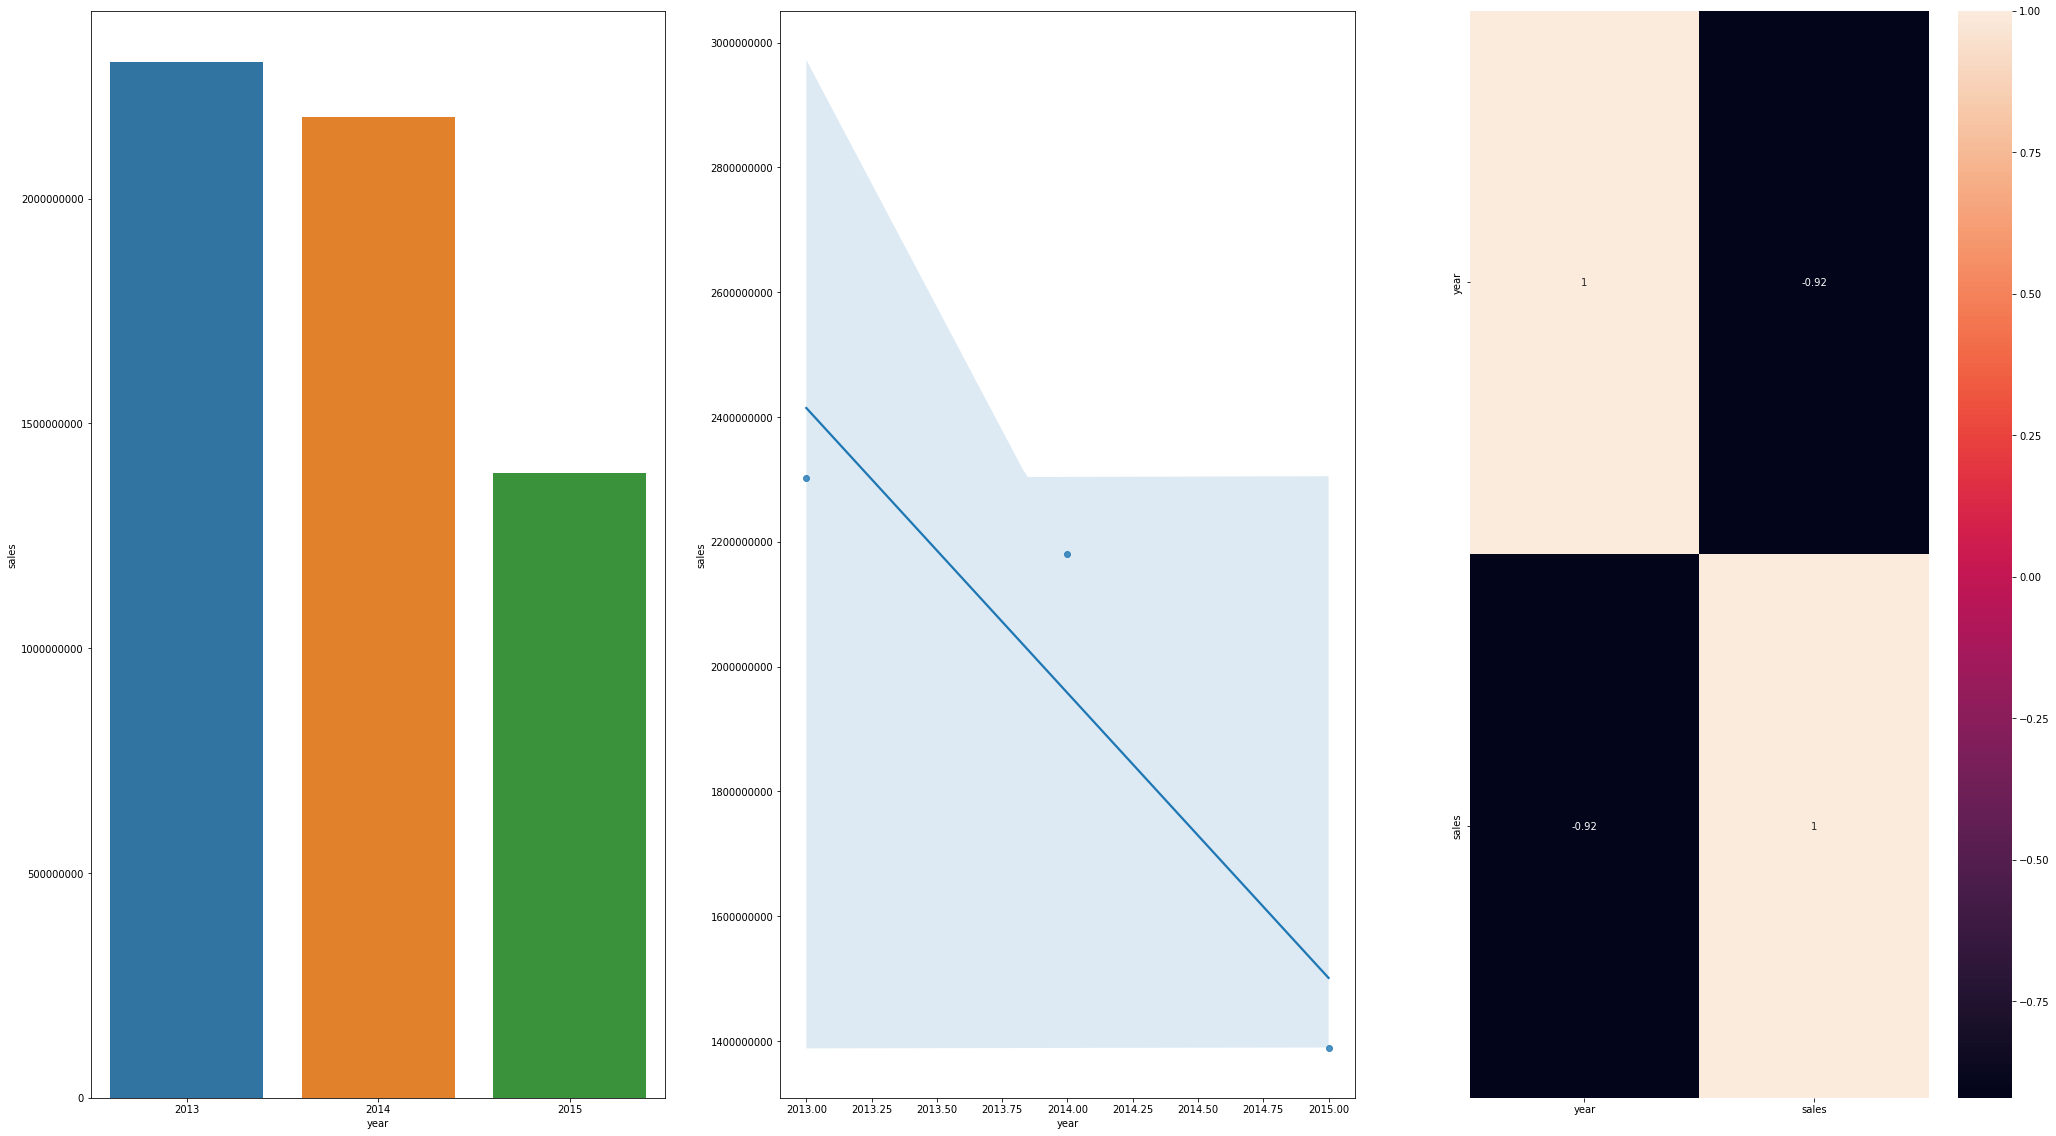

In [49]:
plt.figure(figsize=(35,20))

aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
aux1['year'] = aux1['year'].astype('int64')

plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1);
plt.ticklabel_format(style='plain', axis='y')

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1);
plt.ticklabel_format(style='plain', axis='y')

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

# o ano de 2015 nao fechou todas as vendas ainda

##### **H7:** Stores are supposed to sell more during the second semester of each year.

FALSE: Stores sell less during the second semester of each year.

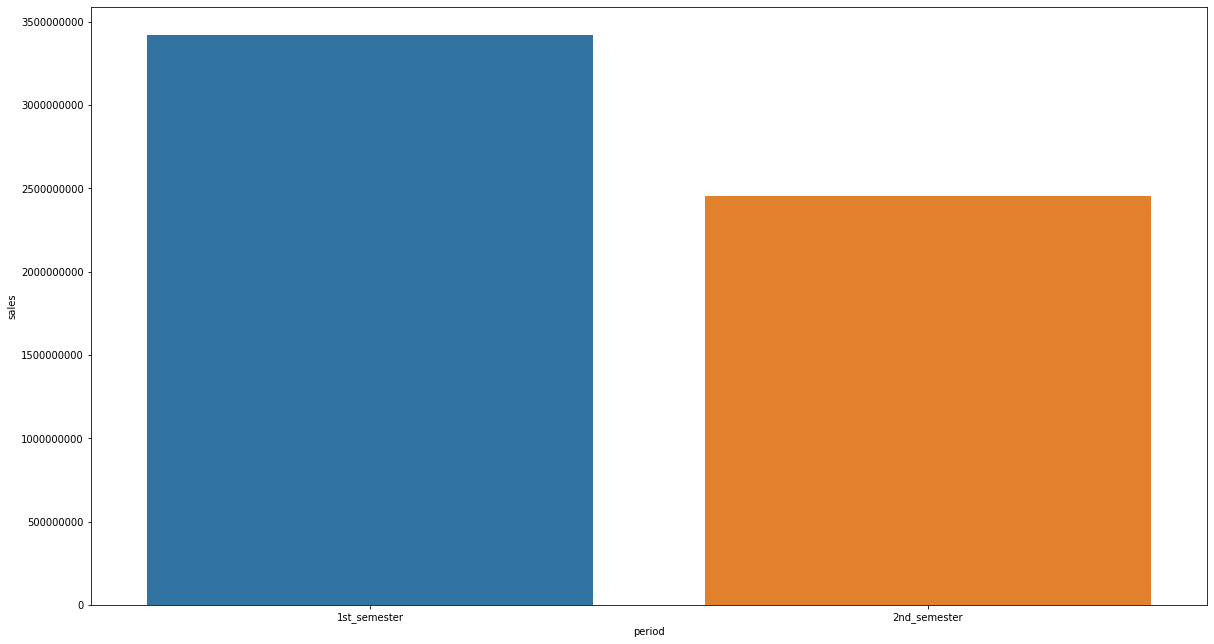

In [50]:
aux1 = df4[df4['month']<=6][['sales']].sum()
aux2 = df4[df4['month']>6][['sales']].sum()
aux3 = pd.DataFrame({'1st_semester':aux1, '2nd_semester':aux2}).T.reset_index().rename({'index':'period'},axis=1) # Diving the sales sum into two periods: 1st_semester and 2nd_semester

plt.figure(figsize=(20,11))
sns.barplot(x='period',y='sales', data=aux3) # Periods sales sum
plt.ticklabel_format(style='plain', axis='y')

##### **H8:** Stores are supposed to sell more after the 10th day of each month. 

TRUE: Stores Sell more after the 10th day of each month.

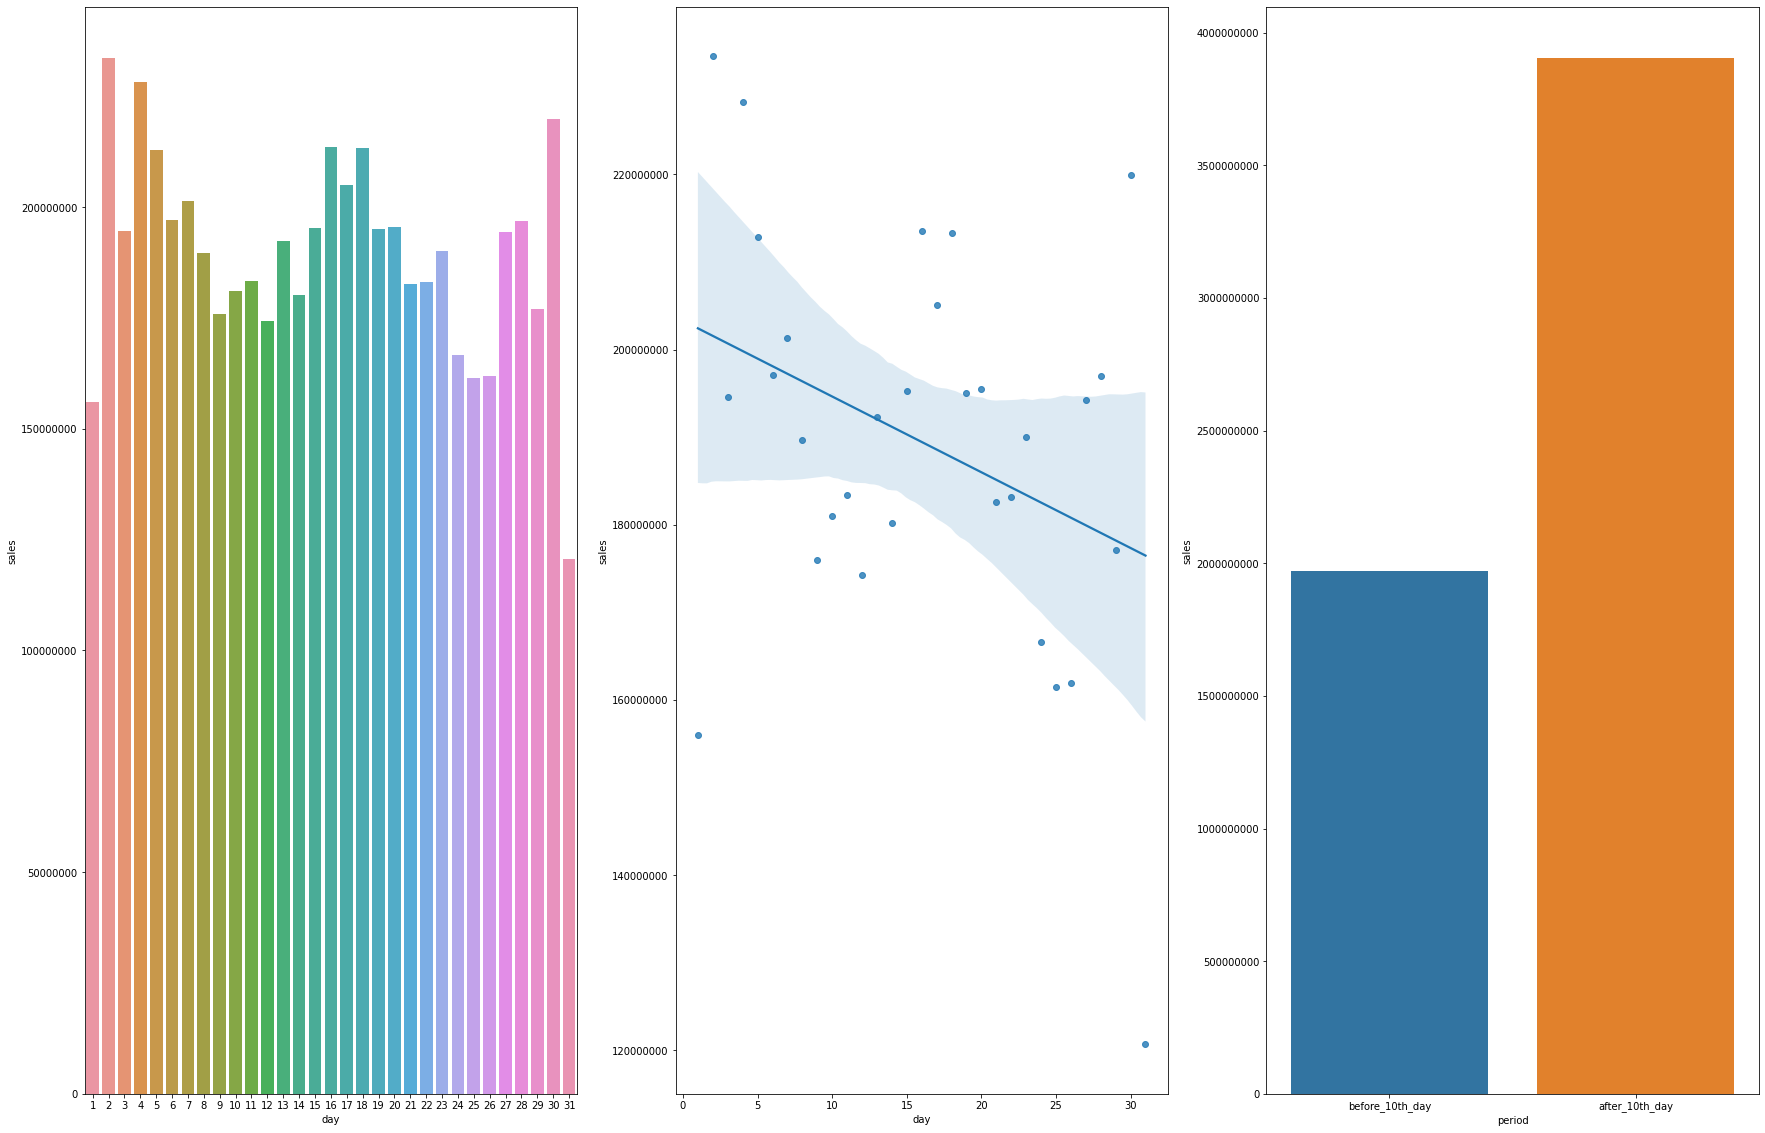

In [51]:
aux1 = df4[df4['day']<=10][['sales']].sum()
aux2 = df4[df4['day']>10][['sales']].sum()
aux3 = pd.DataFrame({'before_10th_day':aux1, 'after_10th_day':aux2}).T.reset_index().rename({'index':'period'},axis=1) # Diving the sales sum into two periods: before_10th_day and after_10th_day

aux4 = df4[['day','sales']].groupby('day').sum().reset_index() # Getting the sales sum per day

plt.figure(figsize=(30,20))

plt.subplot(1,3,1)
sns.barplot(x='day',y='sales', data=aux4) # Daily sales sum
plt.ticklabel_format(style='plain', axis='y')

plt.subplot(1,3,2)
sns.regplot(x='day',y='sales', data=aux4) # Sales over days trend
plt.ticklabel_format(style='plain', axis='y')

plt.subplot(1,3,3)
sns.barplot(x='period',y='sales', data=aux3) # Period bar plot 
plt.ticklabel_format(style='plain', axis='y')

##### **H9:** Stores are supposed to sell less during the weekend.

TRUE: Stores sell less during the weekend.

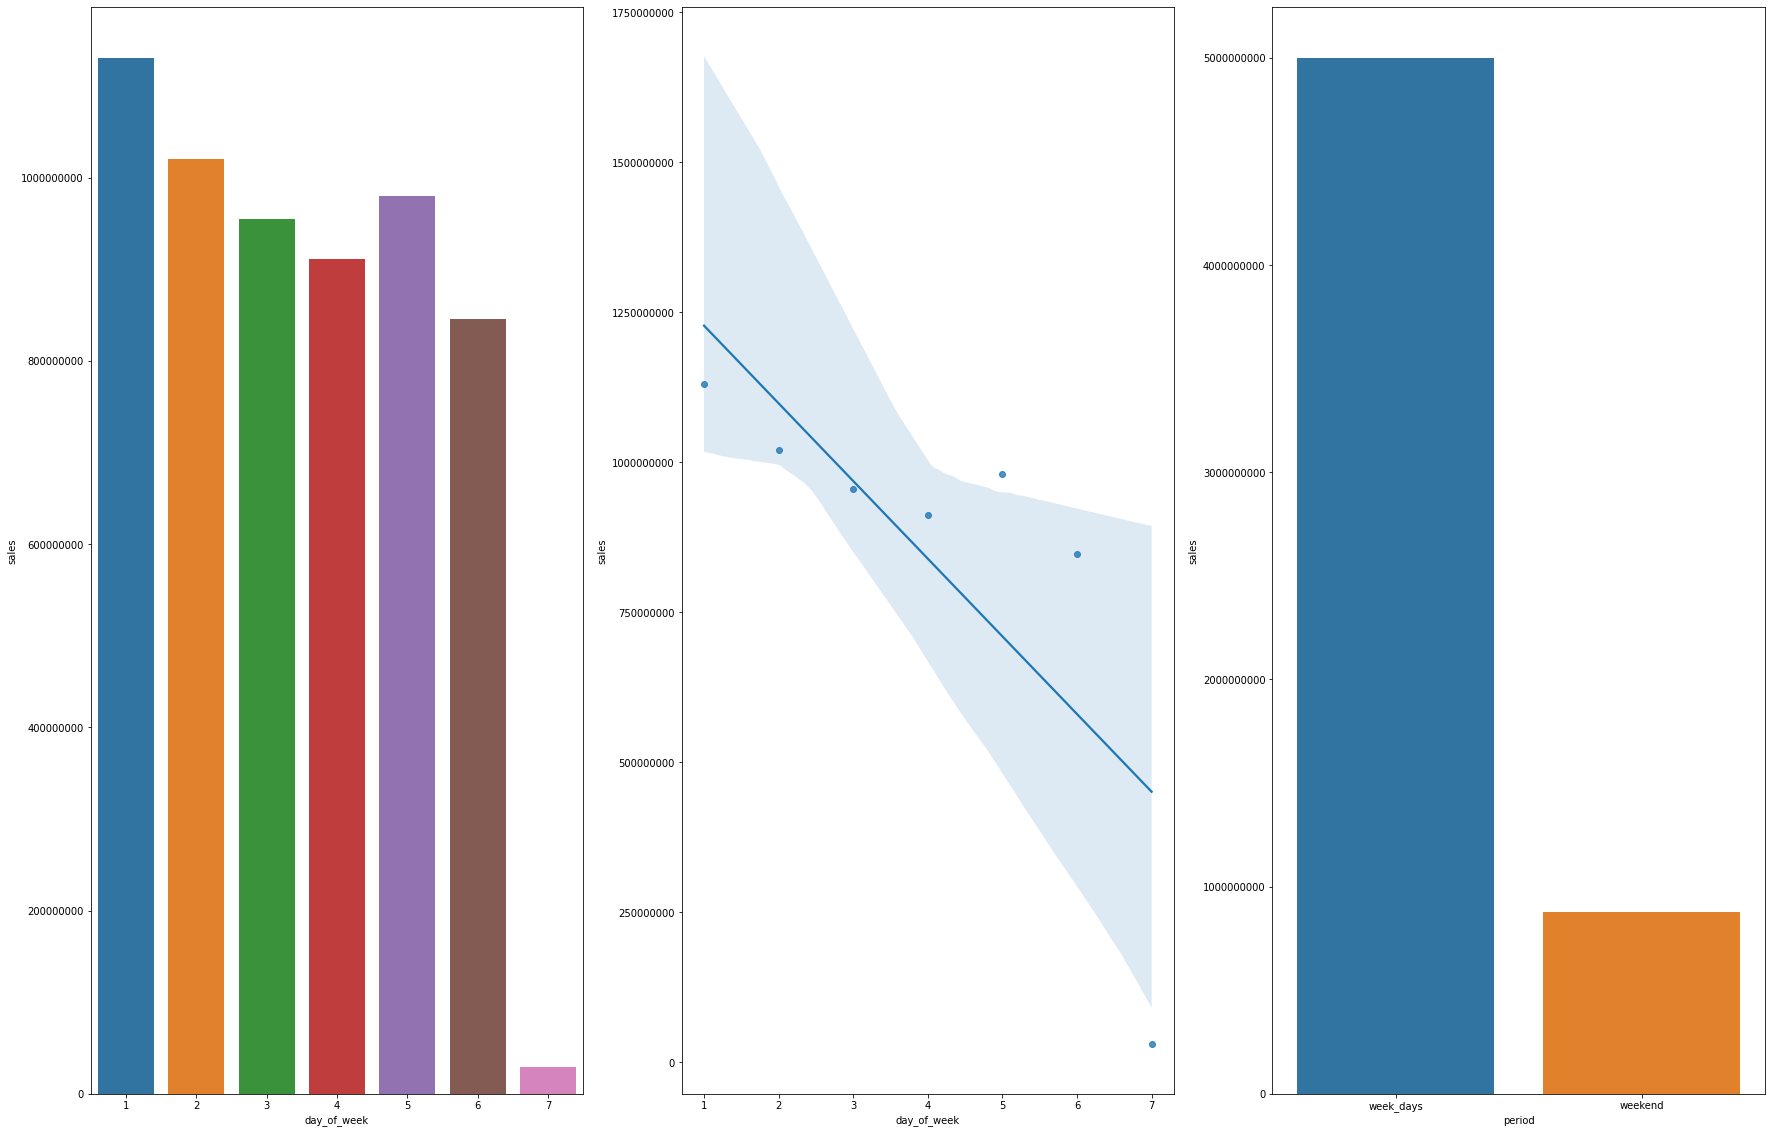

In [52]:
aux1 = df4[df4['day_of_week']<=5][['sales']].sum()
aux2 = df4[df4['day_of_week']>5][['sales']].sum()
aux3 = pd.DataFrame({'week_days':aux1, 'weekend':aux2}).T.reset_index().rename({'index':'period'},axis=1) # Diving the sales sum into two periods: week_days and weekend

aux4 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index() # Getting the sales sum per day_of_week

plt.figure(figsize=(30,20))

plt.subplot(1,3,1)
sns.barplot(x='day_of_week',y='sales', data=aux4) # Daily sales sum
plt.ticklabel_format(style='plain', axis='y')

plt.subplot(1,3,2)
sns.regplot(x='day_of_week',y='sales', data=aux4) # Sales over days_of_week trend
plt.ticklabel_format(style='plain', axis='y')

plt.subplot(1,3,3)
sns.barplot(x='period',y='sales', data=aux3) # Period bar plot 
plt.ticklabel_format(style='plain', axis='y')

##### **H10:** Stores are supposed to sell less during school holidays.

TRUE: Stores sell less during school holidays, except in August.

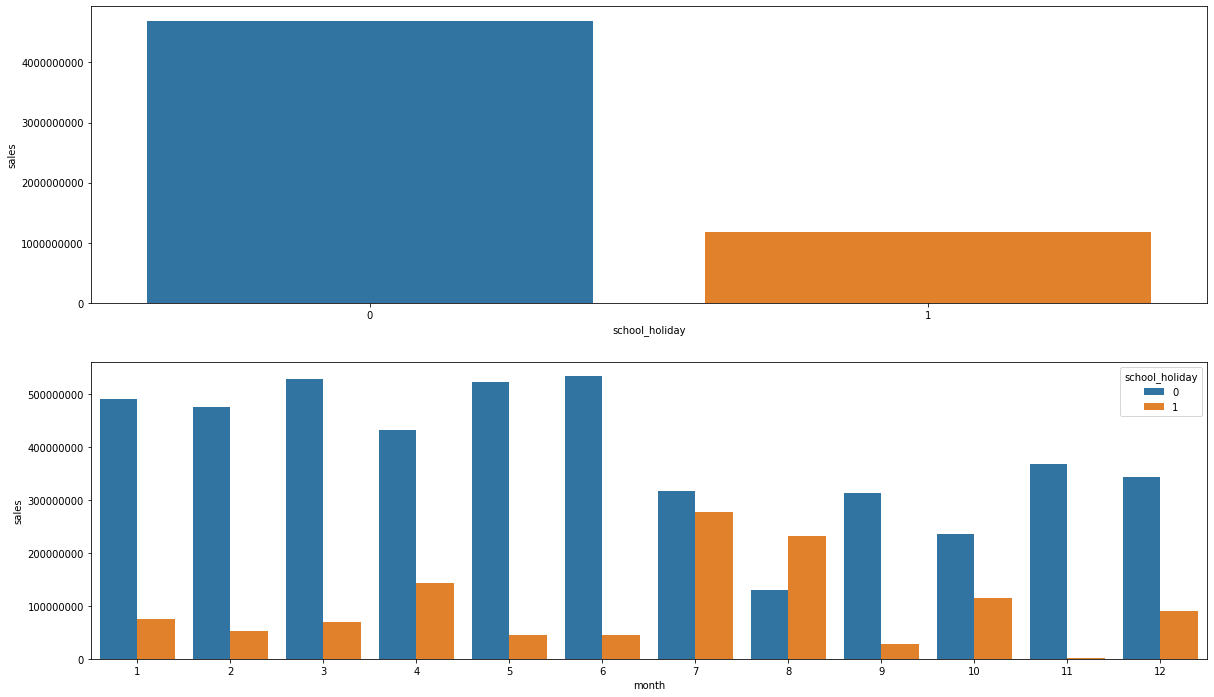

In [53]:
plt.figure(figsize=(20,12))

aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2, 1, 1)
sns.barplot( x='school_holiday', y='sales', data=aux1)
plt.ticklabel_format(style='plain', axis='y')

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()
plt.subplot(2, 1, 2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2)
plt.ticklabel_format(style='plain', axis='y')

5.2.1. **Hypotheses Summary**

| **Hypothesis** | **Conclusion** | **Relevance** |
|:---:|:---:|:---:|
| H1 | False | Low |
| H2 | False | Medium |
| H3 | False | Medium |
| H4 | False | Low |
| H5 | False | Medium |
| H6 | False | High |
| H7 | False | High |
| H8 | True | High |
| H9 | True | High |
| H10 | True | Low |

Obs: **Relevance** represents the ESTIMATED importance of each hypothesis for the algorithm. This estimation is purely based on business knowledge, as well as in the above analysis. For some hypotheses the estimated relevance could be wrong (when evaluating the fitted model). 

#### 5.3. **Multivariate Analysis**

5.3.1. **Numerical Variables**

In order to check correlation between all numerical variables in the dataset a pearson correlation (ADICIONAR LINK) will be displayed below:

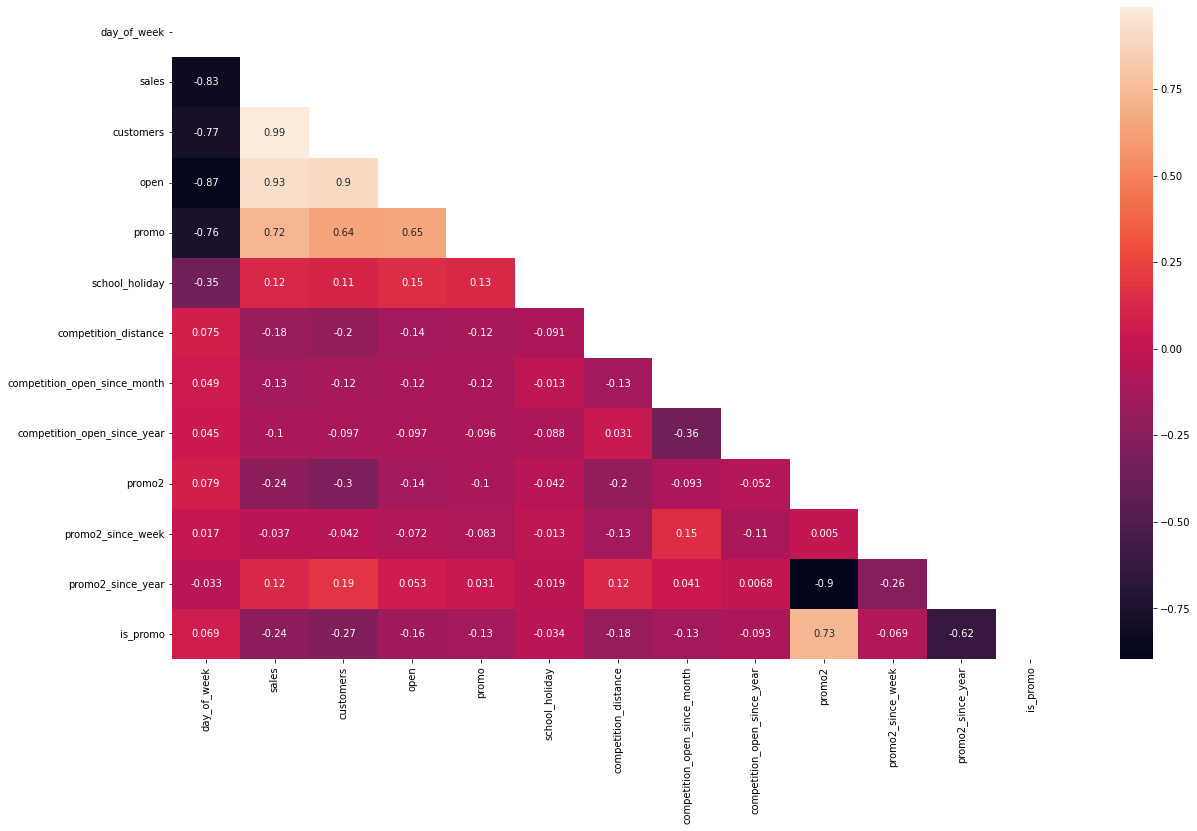

In [54]:
corr = num_attributes.corr(method='pearson').corr() # Pearson Corr
mask = np.triu(corr) # Cleaner heatmap - Only plotting the lower triangle

plt.figure(figsize=(20,12)) # Heatmap size
sns.heatmap(corr, annot=True, mask=mask);

5.3.2. **Categorical Variables**

In order to check correlation between all categorical variables in the dataset a Cramér's V correlation matrix will be displayed below:

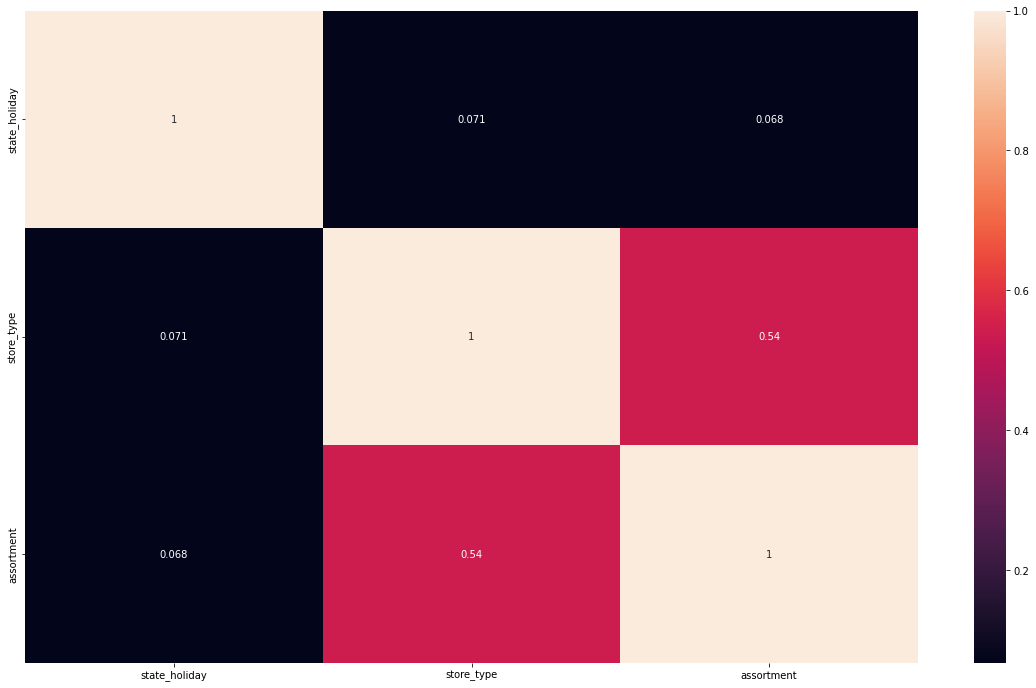

In [55]:
cat = df4.select_dtypes(include='object').drop(columns=['year_week']) # Select only categorical data
cramers_matrix(cat)

## 6. **Data Preparation**

In [56]:
df5 = df4.copy()

#### 6.1. **Normalization**

The normalized variables are the ones close to a Normal Distribution. The normalization process is as follows:

${x}' =  \frac{x_{i} - \mu}{\sigma}$

Where ${x}'$ is the new value for each observation. **For this dataset, none of the variables follow a Normal Distribution.**

#### 6.2. **Rescaling**

The selected rescaling methods for this dataset are: Robust Scaler and Min Max Scaler. Robust Scaler is mostly used to deal with outliers, its formula is: 

${x}' =  \frac{x_{i} - Q_{1}(x)}{Q_{3}(x)- Q_{1}(x)}$

Whereas Min Max Scaler can be used when no significant outliers are present:

${x}' =  \frac{x - x_{min}}{x_{max} - x_{min}}$

In [57]:
num_df5 = df5.select_dtypes(include=['int64','float64'])
num_df5.columns

Index(['store', 'day_of_week', 'sales', 'promo', 'school_holiday',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'is_promo', 'day', 'week_of_year', 'month',
       'year'],
      dtype='object')

The variables 'competition_distance', 'year', 'competition_time_month', 'promo_time_week' will be rescaled. In the other hand, 'day', 'month', 'day_of_week', 'week_of_year' firstly need to be transformed, as those are cyclical variables.

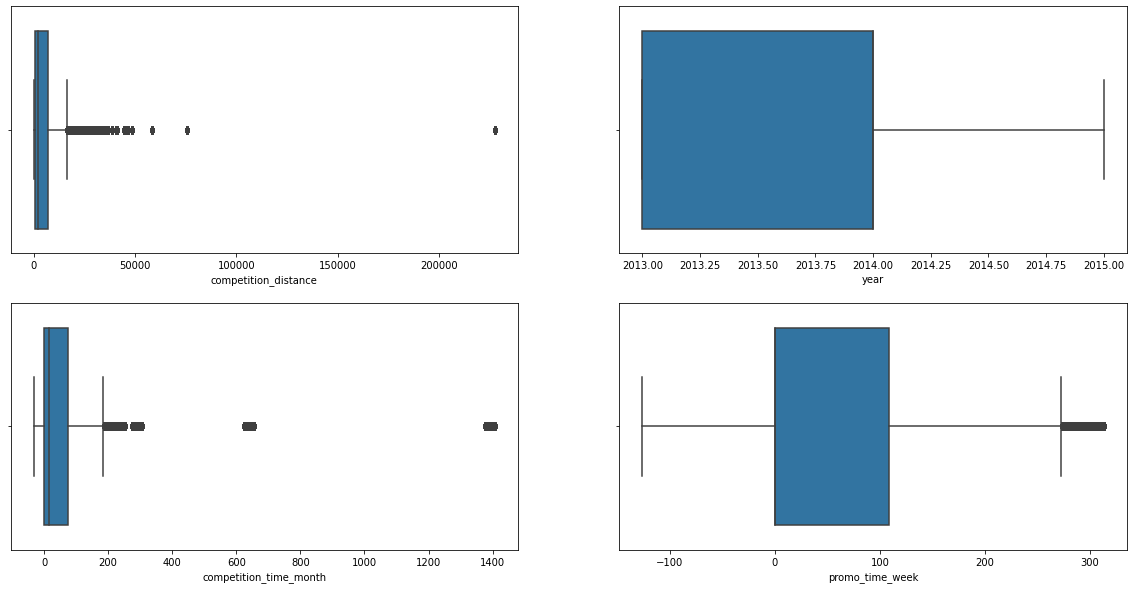

In [58]:
plt.figure(figsize=(20,10))            

plt.subplot(2,2,1)
sns.boxplot(x = df5['competition_distance'], orient='h')

plt.subplot(2,2,2)
sns.boxplot(x = df5['year'], orient='h')

plt.subplot(2,2,3)
sns.boxplot(x = df5['competition_time_month'], orient='h')

plt.subplot(2,2,4)
sns.boxplot(x = df5['promo_time_week'], orient='h')
plt.show()

As seen above for 'competition_distance' and 'competition_time_month' Robust Scaler will be used. As for 'promo_time_week' and 'year' Min Max Scaler will be applied.

In [59]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
# pickle.dump(rs, open('rossmann-app/parameters/competition_distance_scaler.pkl', 'wb')) # Saving for deployment

# competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
# pickle.dump(rs, open('rossmann-app/parameters/competition_time_month_scaler.pkl', 'wb')) # Saving for deployment

# promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
# pickle.dump(mms, open('rossmann-app/parameters/promo_time_week_scaler.pkl', 'wb')) # Saving for deployment

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
# pickle.dump(mms, open('rossmann-app/parameters/year_scaler.pkl', 'wb')) # Saving for deployment

#### 6.3. **Transformation**

6.3.1. **Encoding**

In [60]:
# state_holiday - One Hot Encoding 
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
# pickle.dump(le, open('rossmann-app/parameters/store_type_scaler.pkl', 'wb')) # Saving for deployment

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

6.3.2. **Response Variable Transformation**

It's important to apply a transformation technique in the response variable, so that it could be closer to a normal distribution, because the algorithms work better in this distribution. 

In [61]:
df5['sales'] = np.log1p(df5['sales']) # Logarithm Transformation 

6.3.3. **Nature Transformation** 

Some date/period variables have a cyclical nature, such as days, months, week of year, and so on. If no transformation is applied to those features there's information loss on the model, as it would count the 12th month on each year as far from the 1st, however they are one month apart. To overcome this problem, a **Nature Cyclical Transformation** can be used, where each period is a combination of $sin$ and $cos$.

**In this dataset 'day', 'month', 'day_of_week' and 'week_of_year' have that cyclical behavior.** 

In [62]:
cols = {'day_of_week': 7, # day_of_week transformation
        'month': 12, # month transformation
        'day': 30, # day transformation
        'week_of_year': 52} # week_of_year transformation

for period, cycle in cols.items():
    nature_encode(df5, period, cycle)

In [63]:
df5.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'school_holiday',
       'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'day',
       'week_of_year', 'year_week', 'month', 'year', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week',
       'state_holiday_christmas', 'state_holiday_easter_holiday',
       'state_holiday_public_holiday', 'state_holiday_regular_day',
       'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos',
       'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos'],
      dtype='object')

## 7. **Feature Selection**

In [64]:
df6 = df5.copy()

#### 7.1. **Split dataframe into training and test dataset**

In [65]:
cols_drop = ['week_of_year', 'day','month','day_of_week','promo_since','competition_since','year_week'] # Used as auxiliary columns
df6 = df6.drop(cols_drop, axis=1)

The dataset can't be split randomly into train and test, since we're dealing with time series data. Therefore, because the goal here is to predict the sales value 6 weeks ahead, the train split will be all data from the beginning up to 6 weeks before the dataset end. Thus, the test split will be all data from weeks before the dataset end to its end. For this dataset, the split will be:

- **Train Data: 2013-01-01 (min period) to 2015-06-18**
  
- **Test Data: 2015-06-19 to 2015-07-31 (max period)**

In [66]:
# Training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# Test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

#### 7.2. **Boruta as a Feature Selector**

Boruta is an algorithm used for feature selection, mostly used alongside a Random Forest. In a nutshell, Boruta works as follows:

- Firstly *Shadow Features* are created, those are exact copies of the original features, however in random order. 
- Then, a ML model is trained (e.g. Random Forest) using both original and shadow features.
- The importance of each feature (original and shadow) is assign by Boruta.
- Only the features statistically more important than the shadow features are kept in the final model.

In [67]:
# # Train and Test for Boruta
# X_train_n = X_train.drop('date', axis=1).values
# y_train_n = y_train.values.ravel() # ravel creates a vector

# # Random Forest
# rf = RandomForestRegressor(n_jobs=-1)

# # Initialize and fit Boruta
# boruta = BorutaPy(rf, # Select model for Boruta algorithm -> Random Forest
#                   n_estimators='auto', # Number of estimators as auto
#                   verbose=2, # Boruta prints its iterations
#                   random_state=42).fit(X_train_n, y_train_n)

7.2.1. **Best Features from Boruta** 

In [68]:
# # Best features
# X_train_fs = X_train.drop(['date'], axis=1) # X_train feature selection (same as X_train_n, but as a DataFrame instead of array)
# cols_selected = boruta.support_.tolist() # Gets all features boruta model considered as relevant
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list() # List of selected features

# # Not selected - Boruta
# cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns,cols_selected_boruta))

#### 7.3. **Selecting the Features**

Not necessarily all features found to be relevant by Boruta have to be included in the ML model. However, for a first model train we'll be adding those in the model, as well as week_of_year_sin and month_sin, as their respective $cos$ were considered to be relevant variables. Both 'date' and 'sales' also have to be added back, because those were removed previously. 

In [69]:
# Features used in ML mode
cols_selected_boruta = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'month_sin', # Manually added
                        'month_cos',
                        'day_sin',
                        'day_cos',
                        'week_of_year_sin', # Manually added
                        'week_of_year_cos']

# Columns to add back
feat_to_add = ['date', 'sales']

# Final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add) # adds 'date' and 'sales' in the end

## 8. **Machine Learning Modeling**

A cross validation function was created (available at 1.2 Helper Functions), with 4 arguments:

- training -> The X_train dataset + 'sales' and 'date', because the function cross_validation uses both columns ('sales' and 'date') to split data into train (x,y) and validation (x,y).
  
- k_fold -> Number of folds in cross validation. For all models k_fold=5 will be used.
  
- model_name -> The model name as a string.
  
- model -> The initialized model (e.g. LinearRegression(), SVR(), etc).

This function splits the data into train and validation, fits the given model for each k_fold, makes predictions and returns a DataFrame with the **mean +/- std** (of k models) for four performance metrics:

- MAE - Mean Absolute Error
- MAPE - Mean Absolute Percentage Error
- RMSE - Root Mean Squared Error
- R2 - Coefficient of Determination

## **Metrics Definition and Interpretation**


| **_Metric_** | **_Definition_** |
|:---:|:---:|
| _MAE_ | _Mean Absolute Error_ |
| _MAPE_ | _Mean Absolute Percentage Error_ |
| _RMSE_ | _Root Mean Squared Error_ |
| _R<sup>2</sup>_ | _Coefficient of Determination_ |

<p align="justify"> <i> R<sup>2</sup> basically show how well the sales are being predicted by the model, and alongside RMSE isn't the best metric to translate into financial performance, despite being key to check statistical performance. 

Both MAE and MAPE are really useful in explaining the model's business performance. MAE shows how much the model prediction is wrong on average, while MAPE shows how much the model prediction is wrong on average percentage-wise. </i> </p>

In [70]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation
training = X_train[cols_selected_boruta_full] # Adding the sales and date column, so that the data can be split using time series cross validation

Six models will be trained:

- Average Model (used as a baseline model)
- Linear Regression
- Lasso Regression (Regularized Linear Regression)
- Random Forest Regressor
- XGBoost Regressor
- Light GBM Regressor

#### 8.1. **Average Model (Baseline)**

For the Average Model, due to it not using any built algorithm and since it's a baseline model, we won't be using the cross_validation function. The ml_error function will be used, returning a DataFrame with MAE, MAPE and RMSE.

In [71]:
baseline = x_test.copy() # Sets the x_test as the baseline dataframe
baseline['sales'] = y_test.copy() # Creates a new column in the baseline dataframe named 'sales' (actual sales values)

# Model
pred_baseline = baseline[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'}) # Creates a prediction column, where the predicted values is the mean for each store

# Prediction
baseline = pd.merge(baseline, pred_baseline, how='left', on='store') # Adds the predictions (pred_baseline) 
y_pred_baseline = baseline['predictions'] # predictions

# Metrics
baseline_result = ml_error('Average Model (Baseline)', np.expm1(y_test), np.expm1(y_pred_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE,R2
0,Average Model (Baseline),1354.80000,0.20640,1835.14000,0.63660


#### 8.2. **Linear Regression**

In [72]:
# Model
lr = LinearRegression()

# Using cross validation function
lr_result = cross_validation(training, 5, 'Linear Regression', lr)
lr_result

,Model Name,MAE,MAPE,RMSE,R2
0,Linear Regression,2081.72 +/- 295.57,0.3026 +/- 0.0166,2953.15 +/- 468.22,0.1353 +/- 0.0721


#### 8.3. **Lasso Regression (Regularized Linear Regression)**

In [73]:
# Model
lrl = Lasso(alpha=0.01)

# Using cross validation function
lrl_result = cross_validation(training, 5, 'Lasso Regression', lrl)
lrl_result

,Model Name,MAE,MAPE,RMSE,R2
0,Lasso Regression,2116.42 +/- 341.46,0.292 +/- 0.0118,3058.12 +/- 504.18,0.0742 +/- 0.0834


Both Linear Regression and Lasso Regression have worst performances in comparison to the simple Average Model. This shows a non linear behavior in our dataset, hence the use of more complex models, such as Random Forest, XGBoost and Light GBM. 

#### 8.4. **Random Forest Regressor**

In [74]:
# Model
rf = RandomForestRegressor(n_jobs=-1, 
                           random_state=42)

# Using cross validation function
rf_result = cross_validation(training, 5, 'Random Forest Regressor', rf)
rf_result

,Model Name,MAE,MAPE,RMSE,R2
0,Random Forest Regressor,838.84 +/- 219.91,0.1162 +/- 0.0233,1257.62 +/- 321.14,0.8409 +/- 0.0527


#### 8.5. **XGBoost Regressor**

In [75]:
# Model
xgb = XGBRegressor(objective='reg:squarederror',
                   n_jobs=-1,
                   random_state=42,
                   n_estimators=1000) # Setting 1000 estimators for a (at least) decent performance

# Using cross validation function
xgb_result = cross_validation(training, 5, 'XGBoost Regressor', xgb)
xgb_result

,Model Name,MAE,MAPE,RMSE,R2
0,XGBoost Regressor,900.29 +/- 152.53,0.1273 +/- 0.0155,1293.45 +/- 214.31,0.8322 +/- 0.0334


#### 8.6. **LGBM Regressor**

In [76]:
# LIGHT GBM

model_lgbm = LGBMRegressor(objective= 'regression',
                           random_state=42,
                           n_estimators=1000) # Setting 1000 estimators for a (at least) decent performance

# Using cross validation function
lgbm_result = cross_validation(training, 3, 'LGBM Regressor', model_lgbm)
lgbm_result

,Model Name,MAE,MAPE,RMSE,R2
0,LGBM Regressor,833.23 +/- 121.0,0.1178 +/- 0.0093,1197.68 +/- 176.39,0.8467 +/- 0.0237


#### 8.6. **Comparing Models Performance**

In [77]:
modeling_result = pd.concat([baseline_result.astype(str), lr_result, lrl_result,rf_result, xgb_result, lgbm_result])
modeling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE,R2
0,LGBM Regressor,833.23 +/- 121.0,0.1178 +/- 0.0093,1197.68 +/- 176.39,0.8467 +/- 0.0237
0,Random Forest Regressor,838.84 +/- 219.91,0.1162 +/- 0.0233,1257.62 +/- 321.14,0.8409 +/- 0.0527
0,XGBoost Regressor,900.29 +/- 152.53,0.1273 +/- 0.0155,1293.45 +/- 214.31,0.8322 +/- 0.0334
0,Average Model (Baseline),1354.8,0.2064,1835.14,0.6366
0,Linear Regression,2081.72 +/- 295.57,0.3026 +/- 0.0166,2953.15 +/- 468.22,0.1353 +/- 0.0721
0,Lasso Regression,2116.42 +/- 341.46,0.292 +/- 0.0118,3058.12 +/- 504.18,0.0742 +/- 0.0834


The **Light GBM** model will be chosen for hyperparameter tuning, since it has the lowest RMSE. Even if we look into other metrics, such as MAPE (on which Random Forest has the best performance), Light GBM would still be better to use, because it's much faster to train and tune.

## 9. **Hyperparameter Fine Tuning**

#### 9.1. **Random Search**

An important task in ML modeling is Hyperparameter Tuning, on which the goal is to find the **best possible combination of model hyperparameters**. One way of doing this is by using the Random Search (RS) method. The way it works is very self explanatory: 

- A set of possible model hyper-parameters (search space) is defined.

- RS looks for random combinations of these parameters and trains each model.
  
- The metrics for each model are saved for latter comparison.
  
- The amount of times RS performs such process can be chosen.

RS pros:
- It's **much** faster than other tuning techniques, such as Bayesian Optimization and specially Grid Search.
- Overall the results are good with not so much computational effort .

RS cons:
- It doesn't go over all combinations of hyper-parameters, therefore could miss out on the best possible combination, unlike Grid Search.
- It considers all hyper-parameters equally important to the model, as it runs through them randomly, unlike Bayesian Optimization.

In [78]:
# # Using RS on LGBM model 

# trials = 40
# search_space = { # parameters to be tunned
# 'n_estimators': [3000, 3500, 4000, 4500, 5000], # Higher number of estimators
# 'learning_rate': [0.03, 0.05, 0.07], # Lower learning_rate values
# 'max_depth': [7, 8],
# 'num_leaves': [64, 128]
# }

# random_search_lgbm(search_space, training, trials) # Using the created function (available at 1.2 section) to perform random search optimization in lgbm model

It's possible to set high levels of n_estimators, max_depth and num_leaves for two reasons:
- The dataset is quite large (full data = 1017209 rows; training data = 802942 rows).
- learning_rate's search space is kept at low values.
- subsample, colsample_bytree, min_child_samples were kept at fixed and reasonable values to prevent over-fitting.

#### 9.2. **Final Model**

The Random Search performed on LGBM provided the following hyperparameters as the local optimum (best hyperparameters amongst the tested ones):

| Hyperparameter | Definition | Best Value |
|:---:|:---:|:---:|
| n_estimators | Number of boosting iterations | 4500 |
| learning_rate | Shrinkage rate | 0.03 |
| max_depth | Limit the max depth for tree model | 8 |
| num_leaves | Max number of leaves in one tree | 128 |
| subsample** | Used to randomly select part of data without resampling| 0.7 |
| colsample_bytree**| Used to randomly select a subset of features on each iteration| 0.9 |
| min_child_samples** | Minimal number of data in one leaf | 100 |

** *These parameters were already fixed at certain levels to prevent over-fitting.*

In [79]:
# Tuned parameters
best_param = {
'n_estimators': 4500, 
'learning_rate': 0.03, 
'max_depth': 8, 
'num_leaves': 128
}

# Model
model_lgbm_tuned = LGBMRegressor(objective='regression',
                                random_state=42,
                                subsample=0.7, # prevent over-fitting  
                                colsample_bytree=0.9, # prevent over-fitting  
                                min_child_samples=100, # prevent over-fitting  
        
                                n_estimators=best_param['n_estimators'],
                                learning_rate=best_param['learning_rate'],
                                max_depth=best_param['max_depth'],
                                num_leaves=best_param['num_leaves']).fit(x_train, y_train)

# Prediction
y_pred_lgbm_tuned = model_lgbm_tuned.predict(x_test)

# performance
lgbm_result_tuned = ml_error('LGBM Regressor', np.expm1(y_test), np.expm1(y_pred_lgbm_tuned))
lgbm_result_tuned

,Model Name,MAE,MAPE,RMSE,R2
0,LGBM Regressor,617.54000,0.08940,921.52000,0.90840


## 10. **Financial Results (Performance Metrics Interpretation)**

In [80]:
df9 = X_test[cols_selected_boruta_full]

# Rescale
df9 = df9.assign(sales=np.expm1(df9['sales'])) # Sales back from log to € values
df9['predictions'] = np.expm1(y_pred_lgbm_tuned) # Creates a column with predicted values and convert it back from log to € values

#### 10.1. **Business Performance**

In [81]:
 # Sum of predictions (of the next 6 weeks) by store
df9_pred_6_weeks = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE by store
df9_mae = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})

# MAPE by store
df9_mape = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})

# Merging MAE and MAPE by store
df9_metrics = pd.merge(df9_mae,df9_mape, how='inner', on='store')

# Merging Sum of predictions by store + MAE and MAPE by store
df9_overview = pd.merge(df9_pred_6_weeks, df9_metrics, how='inner', on='store')

# Scenarios
df9_overview['worst_scenario'] = df9_overview['predictions'] - df9_overview['MAE']
df9_overview['best_scenario'] = df9_overview['predictions'] + df9_overview['MAE']

# Order columns
df9_overview = df9_overview[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE','MAPE']]
df9_overview

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,161271.61252,160985.99622,161557.22882,285.61630,0.06470
1,2,175546.43068,175188.63393,175904.22743,357.79675,0.07339
2,3,259570.71961,259071.86575,260069.57348,498.85387,0.07214
3,4,336308.69116,335334.01882,337283.36350,974.67234,0.09265
4,5,176511.88788,176066.10066,176957.67510,445.78722,0.09986
...,...,...,...,...,...,...
1110,1111,179168.17256,178530.57761,179805.76752,637.59495,0.13670
1111,1112,330331.95405,329460.43815,331203.46995,871.51590,0.10553
1112,1113,238349.21815,237836.98536,238861.45095,512.23280,0.07854
1113,1114,769985.91279,767585.95537,772385.87020,2399.95742,0.10165


In [82]:
df9_overview.sort_values('MAPE', ascending=False).head(10) # Top 10 most difficult stores to predict stores

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,105001.45726,101667.20127,108335.71326,3334.25600,0.55366
908,909,233713.69641,226036.46012,241390.93270,7677.23629,0.51534
594,595,279424.24374,272673.19627,286175.29121,6751.04747,0.46912
875,876,203151.37199,199223.02207,207079.72190,3928.34991,0.29152
721,722,355355.26100,353299.60530,357410.91671,2055.65570,0.27740
273,274,199759.24505,198492.15764,201026.33246,1267.08741,0.22045
781,782,216512.02012,215811.96112,217212.07913,700.05900,0.20894
533,534,283298.07346,281998.32166,284597.82526,1299.75180,0.20415
717,718,219562.73301,218083.45112,221042.01490,1479.28189,0.20184
1065,1066,414248.63257,412475.00247,416022.26267,1773.63010,0.19244


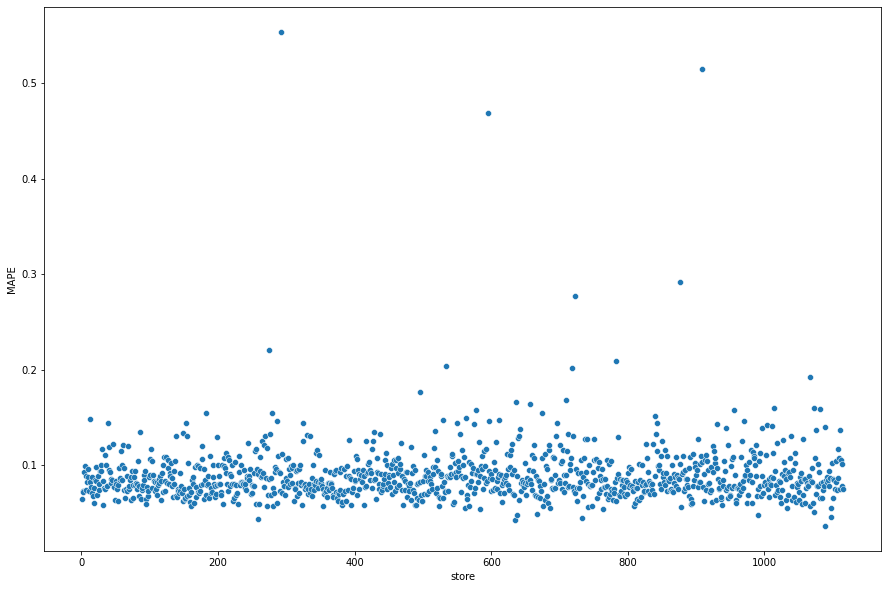

In [83]:
plt.figure(figsize=(15,10))
sns.scatterplot(x='store', y='MAPE', data=df9_overview);

For the stores on which it's more difficult to predict the sales for next 6 weeks a different model could be applied.

#### 10.2. **Total Financial Performance**

In [84]:
df9_total_perf = df9_overview[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenario', 0:'Values'})
df9_total_perf['Values'] = df9_total_perf['Values'].map('${:,.2f}'.format)
df9_total_perf # Total sales predictions, given two scenarios

,Scenario,Values
0,predictions,"$283,782,224.74"
1,worst_scenario,"$283,089,516.00"
2,best_scenario,"$284,474,933.49"


#### 10.3. **Machine Learning Performance**

In [85]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

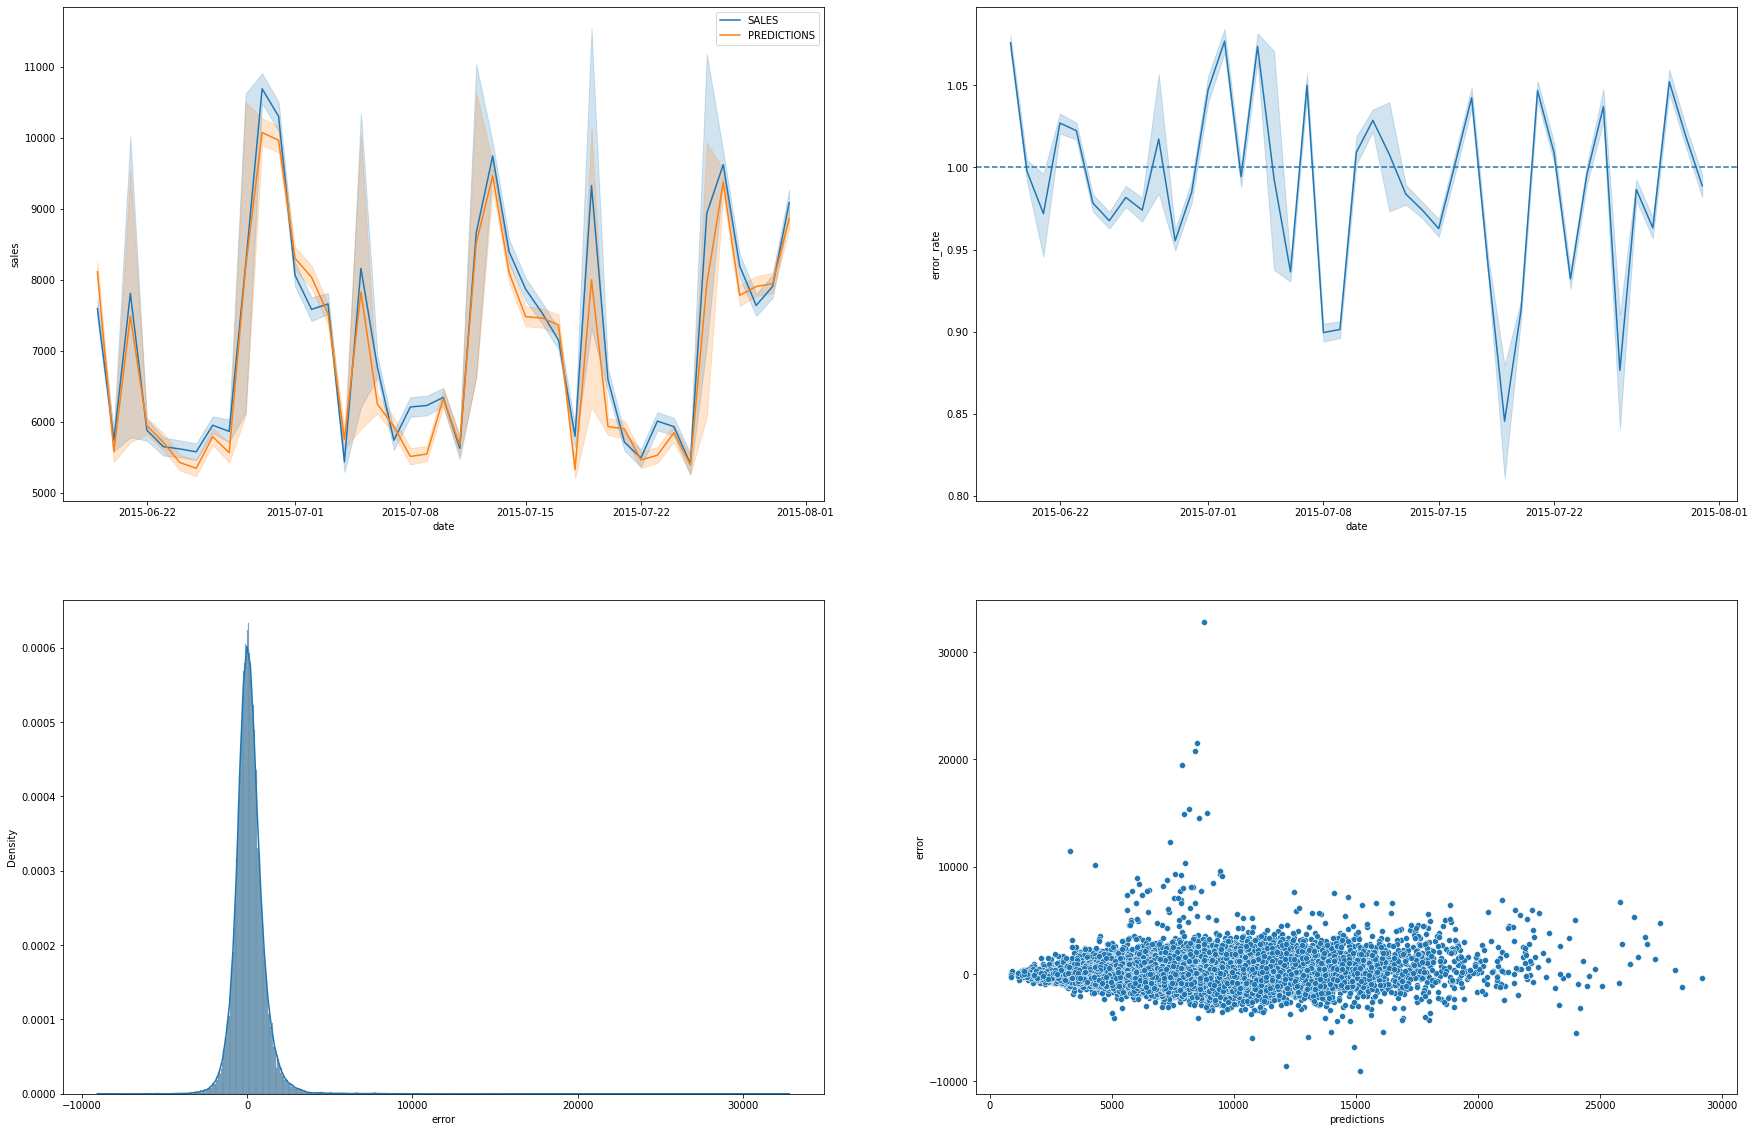

In [86]:
plt.figure(figsize=(30,20))

plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df9)
plt.axhline(1, linestyle='--')

plt.subplot(2, 2, 3)
sns.histplot(df9['error'], kde=True, stat='density')

plt.subplot(2, 2, 4)
sns.scatterplot(x='predictions', y='error', data=df9)

plt.show()

Our ML model evaluation suggests that the model is well fit, since the errors seem to follow a fairly behaved distribution. Looking at the top left corner graph the predictions seem really good.

## 11. **Conclusion and Next Steps**

In this project the main objective was accomplished:

 <p align="justify"> <b> A model that can provide good sales predictions for each store over the next six weeks was successfully trained and deployed in a Telegram Bot, which fulfilled CEO' s requirement, for now it's possible to determine the best resources allocation for each store renovation. </b> In addition to that, five interesting and useful insights were found through Exploratory Data Analysis (EDA), so that those can be properly used by Rossmann CEO. </p>
 
<p align="justify"> Further on, this solution could be improved by a few strategies:

 - Using <a href="https://towardsdatascience.com/an-introduction-to-time-series-analysis-with-arima-a8b9c9a961fb">ARIMA</a> to predict the amount of customers over the next six weeks, so that the customers column could be added to the final model. </p>
 
 - Tune even more the regression algorithm, by applying a <a href="https://machinelearningmastery.com/what-is-bayesian-optimization/">Bayesian Optimization</a> for instance. 
  
 - Try other regression algorithms to predict the sales for each store.
 
 - Use different models for the stores on which it's more difficult (higher MAE and MAPE) to predict the sales


In [87]:
# # Saving the model
# pickle.dump(model_lgbm_tuned, open('rossmann-app/model/model_rossmann.pkl', 'wb'))